## Step 1: Predicting the Most Played Move (Popularity-based Recommendation)

In this initial phase of our recommendation system, we focus on identifying the most popular moves.

### Objective:
The main goal is to recommend the move most frequently played in a given chess position, based on historical data. This forms a simple yet effective 'baseline' recommendation system.

### Approach:
1.  **Data Preparation:** Load the chess game dataset and ensure moves and corresponding positions are correctly parsed and structured.
2.  **Position Identification:** For each move, capture the unique chess position (e.g., using FEN notation, 'Forsyth-Edwards Notation') from which the move was made.
3.  **Frequency Analysis:** Count how often each unique move has been played from a specific, identical chess position to determine its popularity in that context.
4.  **Top N Recommendation:** For a given chess position, present the 'N' most played moves as recommendations. 'N' is a configurable parameter.

### Expected Outcome:
A function that, when provided with a chess position, returns a list of the most played moves in that specific situation, sorted by frequency. These recommendations are purely based on popularity among previous players and do not yet consider game outcomes.

In [1]:
# import
import pandas as pd
import numpy as np

In [2]:
import pandas as pd
from collections import defaultdict

def load_and_process_chess_data(
    csv_path: str,
    dtypes: dict | None = None,
    chunksize: int = 1_000_000
) -> pd.DataFrame:
    """
    Load chess data from a large CSV file (6GB+ safe),
    parse FEN strings, count moves per board position,
    and return sorted results.
    """

    # Accumulator for counts
    counts = defaultdict(int)

    # Stream CSV in chunks
    for chunk in pd.read_csv(
        csv_path,
        dtype=dtypes,
        chunksize=chunksize
    ):
        # Split FEN string
        fen_parts = chunk['fen'].str.split(' ', expand=True)

        # ---- FEN validation ----
        expected_parts = 6

        if fen_parts.shape[1] != expected_parts:
            raise ValueError(
                f"Invalid FEN format: expected {expected_parts} fields, "
                f"got {fen_parts.shape[1]}"
            )

        if fen_parts.isnull().any().any():
            invalid_rows = fen_parts[fen_parts.isnull().any(axis=1)]
            raise ValueError(
                f"Invalid FEN strings detected in {len(invalid_rows)} rows."
            )

        # Assign components (no copy of full DF)
        chunk['board_state'] = fen_parts[0]
        chunk['active_color'] = fen_parts[1]

        # Incrementally aggregate
        grouped = (
            chunk
            .groupby(['board_state', 'active_color', 'move'])
            .size()
        )

        for key, value in grouped.items():
            counts[key] += value

    # Convert accumulated counts to DataFrame
    move_counts = pd.DataFrame(
        (
            (*k, v) for k, v in counts.items()
        ),
        columns=['board_state', 'active_color', 'move', 'count']
    )

    # Sort by frequency
    move_counts_sorted = move_counts.sort_values(
        by='count',
        ascending=False
    )

    return move_counts_sorted

In [3]:
move_counts_sorted = load_and_process_chess_data(csv_path = "/content/drive/MyDrive/Colab Notebooks/DatabaseLichessFiltered/chess_games_filtered.csv")

In [4]:
def MostPayedMoves(fen_string, n=3):
    """
    Beveelt de top N meest gespeelde zetten aan voor een gegeven FEN-string.

    Args:
        fen_string (str): De Forsyth-Edwards Notatie string van de schaakpositie.
        n (int): Het aantal aan te bevelen zetten.

    Returns:
        pandas.DataFrame: Een DataFrame met de aanbevolen zetten en hun frequenties,
                          gesorteerd op frequentie.
    """
    # Parse fen-string information by creating a dictionary

    fen_parts = fen_string.split(' ')

    parsed_fen = {
        'board_state': fen_parts[0],
        'active_color': fen_parts[1],
        'castling_rights': fen_parts[2],
        'en_passant_square': fen_parts[3],
        'halfmove_clock': fen_parts[4],
        'fullmove_number': fen_parts[5]
    }

    # Filter moves for the given FEN string
    fen_moves = move_counts_sorted[(move_counts_sorted['board_state'] == parsed_fen.get('board_state')) &
                                   (move_counts_sorted['active_color'] == parsed_fen.get('active_color'))]

    # Return the top N moves
    return fen_moves.head(n)


In [5]:
# Voorbeeldgebruik:
# Laten we de aanbevolen zetten voor de beginpositie ('rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w KQkq - 0 1') testen
start_fen = 'rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w KQkq - 0 1'
recommended_moves_start = MostPayedMoves(start_fen, n=5)
print(f"Aanbevolen zetten voor de startpositie ({start_fen}):")
display(recommended_moves_start)

# Test met een andere FEN (bijvoorbeeld de FEN na 1. e4)
fen_after_e4 = 'rnbqkbnr/pppppppp/8/8/4P3/8/PPPP1PPP/RNBQKBNR b KQkq - 0 1'
recommended_moves_e4 = MostPayedMoves(fen_after_e4, n=3)
print(f"\nAanbevolen zetten voor de positie na 1. e4 ({fen_after_e4}):")
display(recommended_moves_e4)

Aanbevolen zetten voor de startpositie (rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w KQkq - 0 1):


board_state active_color  move  count
827326  rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR            w  e2e4   9269
827324  rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR            w  d2d4   3962
827329  rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR            w  g1f3   2059
827322  rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR            w  c2c4   1094
827321  rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR            w  c2c3    296


Aanbevolen zetten voor de positie na 1. e4 (rnbqkbnr/pppppppp/8/8/4P3/8/PPPP1PPP/RNBQKBNR b KQkq - 0 1):


board_state active_color  move  \
827266  rnbqkbnr/pppppppp/8/8/4P3/8/PPPP1PPP/RNBQKBNR            b  e7e5   
827262  rnbqkbnr/pppppppp/8/8/4P3/8/PPPP1PPP/RNBQKBNR            b  c7c5   
827267  rnbqkbnr/pppppppp/8/8/4P3/8/PPPP1PPP/RNBQKBNR            b  e7e6   

        count  
827266   4437  
827262   2657  
827267   1111

```markdown
## Limitations of a Popularity-Based Recommendation System

While a recommendation system based on the most frequently played moves can provide a solid baseline, it has several inherent limitations that may affect the quality of its recommendations:

1. **Lack of strategic understanding:**  
   This system does not account for the deeper strategic value of a move or the broader game context. A popular move is not always the best move in a specific position and may even lead to a disadvantageous position in the long run.

2. **No consideration of game outcomes:**  
   The system completely ignores the result of the game. It does not distinguish between moves that lead to a win, loss, or draw. As a result, a move that is frequently played but consistently leads to losses may still be recommended.

3. **No personalization or adaptation to the player:**  
   The system does not adapt to the user’s playing strength or style. A move that is popular among beginners may be suboptimal for advanced players, and vice versa.

4. **“Cold start” problem for new moves:**  
   New, innovative, or less well-known moves—despite potentially being very effective—will never be recommended because they have not yet accumulated sufficient popularity in the dataset. This limits the discovery of new ideas.

5. **Sensitivity to common mistakes:**  
   If a particular mistake or suboptimal move is very popular (for example, a common opening trap), the system will continue to recommend it, causing users to repeatedly make the same errors.

6. **Limited depth of recommendations:**  
   The system cannot recommend complex move sequences or tactical combinations. It focuses solely on individual moves without looking ahead in the game.

These limitations highlight the need to further develop the system using more advanced methods that take game outcomes, strategic insight, and potential pitfalls into account.

```

In [6]:
# Read in data again

In [7]:
df_db = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/DatabaseLichessFiltered/chess_games_filtered.csv")

In [8]:
df_db.columns

Index(['game_id', 'fen', 'move', 'result'], dtype='object')

In [9]:
import pandas as pd
import numpy as np
from collections import defaultdict

def build_move_statistics_with_entropy(
    csv_path: str,
    dtypes: dict | None = None,
    alpha: float = 0.3,
    chunksize: int = 1_000_000
) -> pd.DataFrame:
    """
    Builds move statistics using popularity, win rate,
    and entropy from a large CSV file (6GB+ safe).
    """

    # Accumulators
    move_counts = defaultdict(int)
    score_sums = defaultdict(float)

    for chunk in pd.read_csv(
        csv_path,
        dtype=dtypes,
        chunksize=chunksize
    ):
        # ---- FEN parsing ----
        fen_parts = chunk['fen'].str.split(' ', expand=True)
        expected_parts = 6

        if fen_parts.shape[1] != expected_parts:
            raise ValueError(
                f"Invalid FEN format: expected {expected_parts} fields, "
                f"got {fen_parts.shape[1]}"
            )

        if fen_parts.isnull().any().any():
            invalid_rows = fen_parts[fen_parts.isnull().any(axis=1)]
            raise ValueError(
                f"Invalid FEN strings detected in {len(invalid_rows)} rows."
            )

        chunk['board_state'] = fen_parts[0]
        chunk['active_color'] = fen_parts[1]
        chunk['castling_rights'] = fen_parts[2]
        chunk['en_passant_square'] = fen_parts[3]

        # ---- Vectorized score computation ----
        chunk['score'] = 0.5
        chunk.loc[
            (chunk['result'] == '1-0') & (chunk['active_color'] == 'w'),
            'score'
        ] = 1.0
        chunk.loc[
            (chunk['result'] == '0-1') & (chunk['active_color'] == 'b'),
            'score'
        ] = 1.0
        chunk.loc[
            (chunk['result'] == '1-0') & (chunk['active_color'] == 'b'),
            'score'
        ] = 0.0
        chunk.loc[
            (chunk['result'] == '0-1') & (chunk['active_color'] == 'w'),
            'score'
        ] = 0.0

        # ---- Aggregate per chunk ----
        grouped = (
            chunk
            .groupby([
                'board_state',
                'active_color',
                'castling_rights',
                'en_passant_square',
                'move'
            ])
            .agg(
                count=('move', 'size'),
                score_sum=('score', 'sum')
            )
        )

        for key, row in grouped.iterrows():
            move_counts[key] += row['count']
            score_sums[key] += row['score_sum']

    # ---- Build final DataFrame ----
    rows = []
    for key in move_counts:
        rows.append((*key, move_counts[key], score_sums[key]))

    move_stats = pd.DataFrame(
        rows,
        columns=[
            'board_state',
            'active_color',
            'castling_rights',
            'en_passant_square',
            'move',
            'count',
            'score_sum'
        ]
    )

    # Win rate
    move_stats['win_rate'] = move_stats['score_sum'] / move_stats['count']

    # Total moves per position
    move_stats['total_moves'] = (
        move_stats
        .groupby([
            'board_state',
            'active_color',
            'castling_rights',
            'en_passant_square'
        ])['count']
        .transform('sum')
    )

    # Probability
    move_stats['probability'] = (
        move_stats['count'] / move_stats['total_moves']
    )

    # Entropy / surprise
    move_stats['surprise'] = -np.log(move_stats['probability'])

    # Base score
    move_stats['base_score'] = (
        move_stats['win_rate'] * np.log1p(move_stats['count'])
    )

    # Final entropy-weighted score
    move_stats['final_score'] = (
        move_stats['base_score'] * (1 + alpha * move_stats['surprise'])
    )

    return move_stats.sort_values('final_score', ascending=False)

In [10]:
move_stats = build_move_statistics_with_entropy("/content/drive/MyDrive/Colab Notebooks/DatabaseLichessFiltered/chess_games_filtered.csv", alpha=0.2)

In [11]:
def recommend_moves_with_entropy(
    fen_string: str,
    move_stats: pd.DataFrame,
    n: int = 3
):
    """
    Recommend moves using popularity, success rate, and surprise factor.
    """

    fen_parts = fen_string.split(' ')
    if len(fen_parts) != 6:
        raise ValueError("Invalid FEN string")

    board_state, active_color, castling_rights, en_passant_square, _, _ = fen_parts

    candidates = move_stats[
        (move_stats['board_state'] == board_state) &
        (move_stats['active_color'] == active_color) &
        (move_stats['castling_rights'] == castling_rights) &
        (move_stats['en_passant_square'] == en_passant_square)
    ]

    # Cold-start fallback
    if candidates.empty:
        candidates = move_stats[
            move_stats['board_state'] == board_state
        ]

    return candidates.head(n)[
        [
            'move',
            'count',
            'win_rate',
            'surprise',
            'final_score'
        ]
    ]


In [12]:
# Voorbeeldgebruik:
# Laten we de aanbevolen zetten voor de beginpositie ('rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w KQkq - 0 1') testen
start_fen = 'rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w KQkq - 0 1'
recommended_moves_start = recommend_moves_with_entropy(start_fen, move_stats, n=5)
print(f"Aanbevolen zetten voor de startpositie ({start_fen}):")
display(recommended_moves_start)

# Test met een andere FEN (bijvoorbeeld de FEN na 1. e4)
fen_after_e4 = 'rnbqkbnr/pppppppp/8/8/4P3/8/PPPP1PPP/RNBQKBNR b KQkq - 0 1'
recommended_moves_e4 = recommend_moves_with_entropy(fen_after_e4, move_stats, n=3)
print(f"\nAanbevolen zetten voor de positie na 1. e4 ({fen_after_e4}):")
display(recommended_moves_e4)

Aanbevolen zetten voor de startpositie (rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w KQkq - 0 1):


move   count  win_rate  surprise  final_score
827332  c2c3   296.0  0.719595  4.082222     7.442297
827340  g1f3  2059.0  0.588392  2.142606     6.413639
827333  c2c4  1094.0  0.557130  2.774985     6.063055
827335  d2d4  3962.0  0.538743  1.488077     5.791718
827328  a2a4    66.0  0.628788  5.582927     5.595955


Aanbevolen zetten voor de positie na 1. e4 (rnbqkbnr/pppppppp/8/8/4P3/8/PPPP1PPP/RNBQKBNR b KQkq - 0 1):


move   count  win_rate  surprise  final_score
827278  e7e6  1111.0  0.522502  2.121199     5.219535
827274  c7c6   729.0  0.506173  2.542541     5.034224
827277  e7e5  4437.0  0.486027  0.736481     4.682840

# Task
Install `flask` and `python-chess` libraries. Download the Stockfish chess engine from `https://github.com/official-stockfish/Stockfish/releases/download/sf_16.1/stockfish-ubuntu-x86-64-avx2` and configure it to be accessible, for example, at `/usr/games/stockfish`.

## Install Libraries and Stockfish

### Subtask:
Install the `flask`, `python-chess` libraries and download/configure the Stockfish chess engine executable, ensuring it's accessible.


**Reasoning**:
The first step in the instructions is to install the `flask` and `python-chess` libraries using pip. This command will ensure these dependencies are available for subsequent steps.



In [13]:
pip install flask python-chess

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.1/6.1 MB 45.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for chess: filename=chess-1.11.2-py3-none-any.whl size=147775 sha256=556e0a2d0b028cdd67a1b09b80d42fce0e228aa57c57c1ab795da1fb20da0d21
  Stored in directory: /root/.cache/pip/wheels/83/1f/4e/8f4300f7dd554eb8de70ddfed96e94d3d030ace10c5b53d447
Successfully built chess


In [14]:
# Correct Linux Stockfish binary
STOCKFISH_URL = (
    "https://github.com/official-stockfish/Stockfish/releases/latest/download/stockfish-ubuntu-x86-64-avx2.tar"
)

STOCKFISH_FILENAME = "stockfish-ubuntu-x86-64-avx2.tar"

# Download
!wget -L -O {STOCKFISH_FILENAME} {STOCKFISH_URL}

# Extract
!tar -xvf {STOCKFISH_FILENAME}



--2026-01-20 21:39:25--  https://github.com/official-stockfish/Stockfish/releases/latest/download/stockfish-ubuntu-x86-64-avx2.tar
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/official-stockfish/Stockfish/releases/download/sf_17.1/stockfish-ubuntu-x86-64-avx2.tar [following]
--2026-01-20 21:39:26--  https://github.com/official-stockfish/Stockfish/releases/download/sf_17.1/stockfish-ubuntu-x86-64-avx2.tar
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://release-assets.githubusercontent.com/github-production-release-asset/20976138/85758419-9488-4267-84ea-dc1379a61eb1?sp=r&sv=2018-11-09&sr=b&spr=https&se=2026-01-20T22%3A33%3A16Z&rscd=attachment%3B+filename%3Dstockfish-ubuntu-x86-64-avx2.tar&rsct=application%2Foctet-stream&skoid=96c2d410-5711-43a1-aedd-ab1947aa7ab0&skti

In [15]:
STOCKFISH_PATH = "/content/stockfish/stockfish-ubuntu-x86-64-avx2"

# Make it an executable
!chmod +x {STOCKFISH_PATH}

Stockfish plays white and begins!
Model plays: c2c3


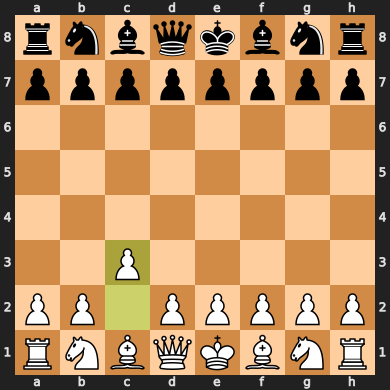

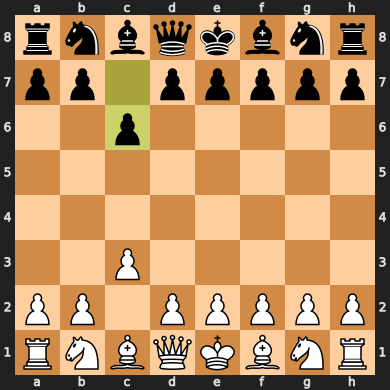

Stockfish plays: c7c6
Model plays: e2e4


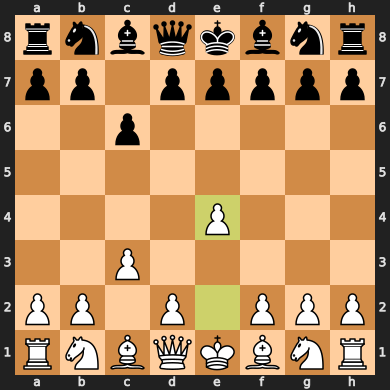

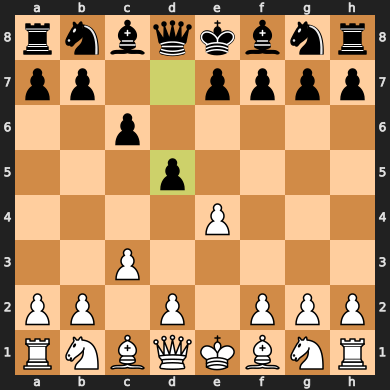

Stockfish plays: d7d5
Model plays: e4e5


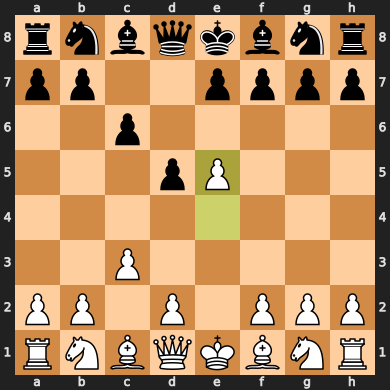

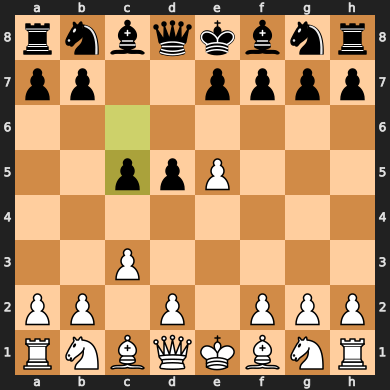

Stockfish plays: c6c5
Fallback to Stockfish: g1f3
Model plays: g1f3


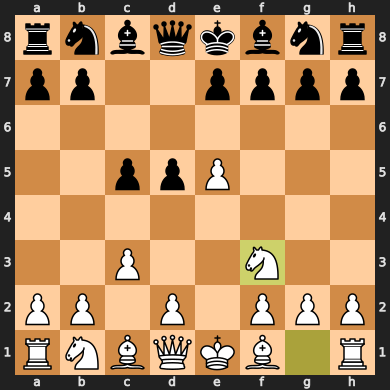

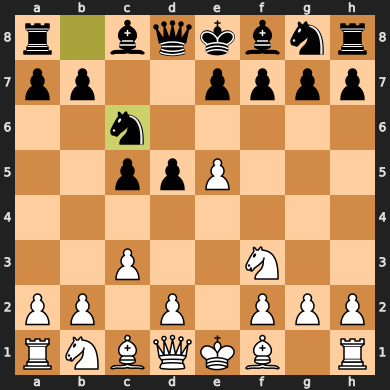

Stockfish plays: b8c6
Fallback to Stockfish: f1b5
Model plays: f1b5


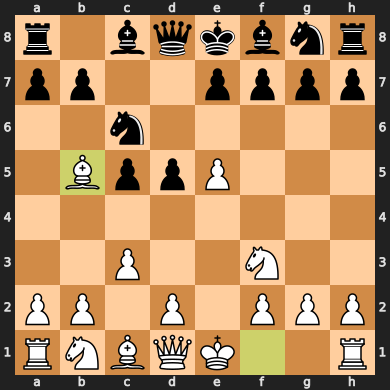

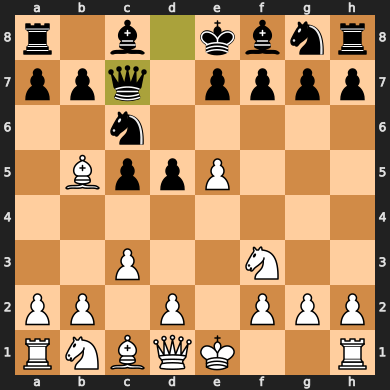

Stockfish plays: d8c7
Fallback to Stockfish: e1g1
Model plays: e1g1


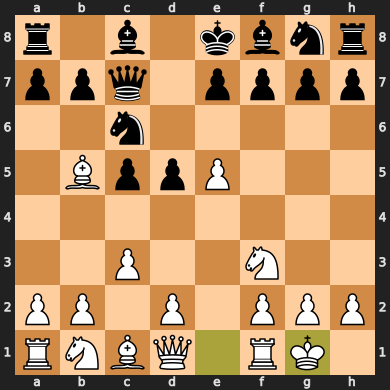

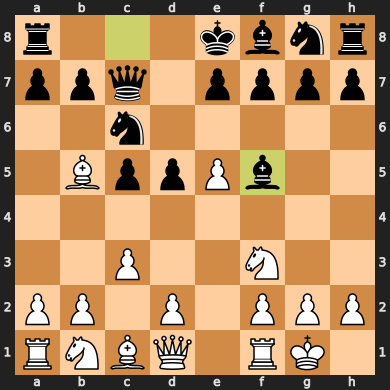

Stockfish plays: c8f5
Fallback to Stockfish: b5a4
Model plays: b5a4


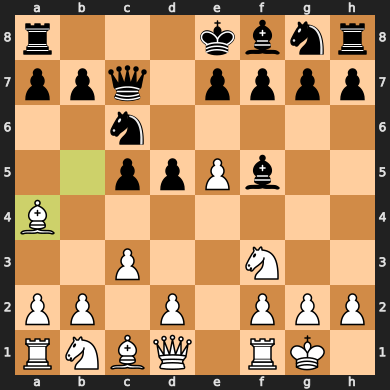

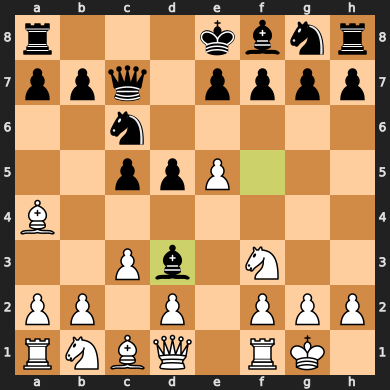

Stockfish plays: f5d3
Fallback to Stockfish: a4c6
Model plays: a4c6


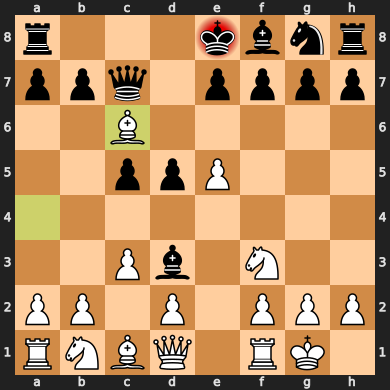

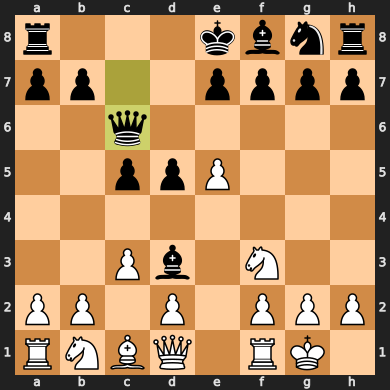

Stockfish plays: c7c6
Fallback to Stockfish: f1e1
Model plays: f1e1


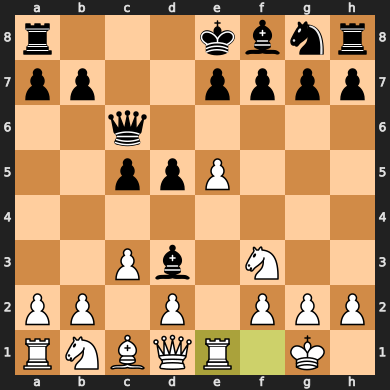

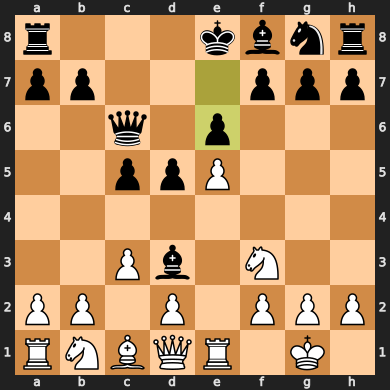

Stockfish plays: e7e6
Fallback to Stockfish: b1a3
Model plays: b1a3


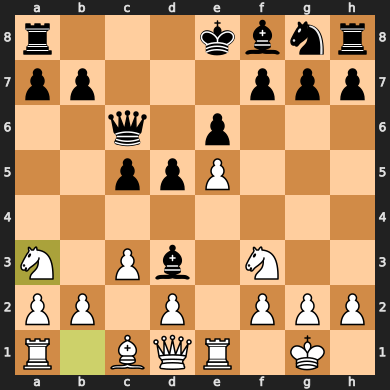

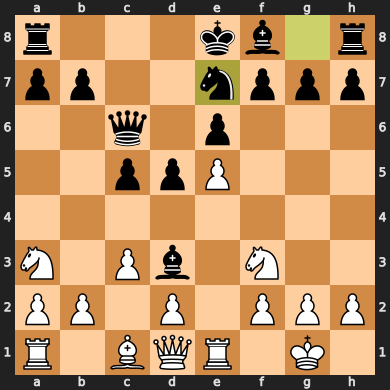

Stockfish plays: g8e7
Fallback to Stockfish: b2b3
Model plays: b2b3


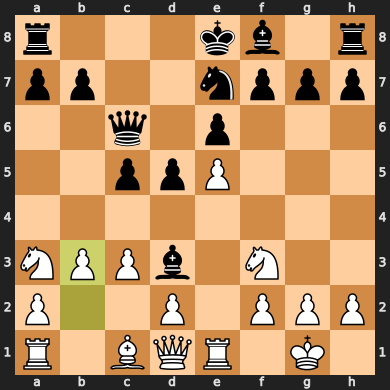

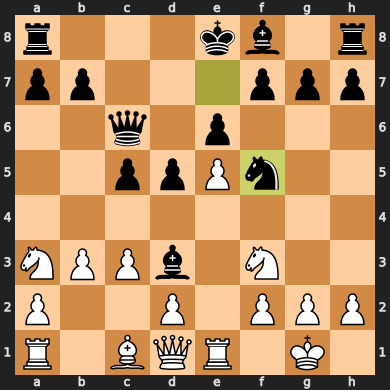

Stockfish plays: e7f5
Fallback to Stockfish: g2g4
Model plays: g2g4


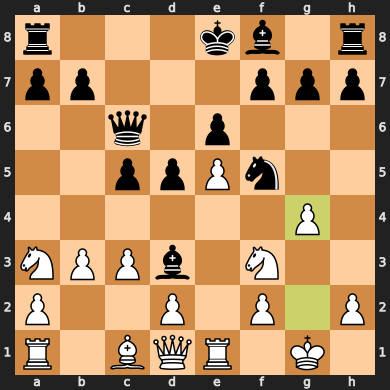

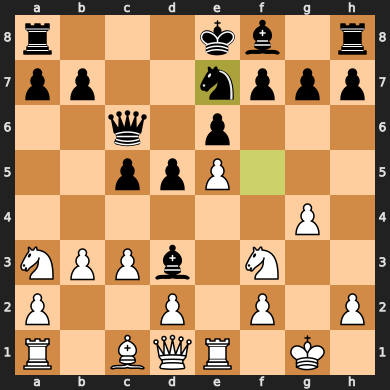

Stockfish plays: f5e7
Fallback to Stockfish: a3c2
Model plays: a3c2


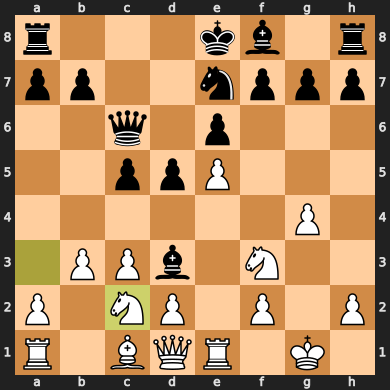

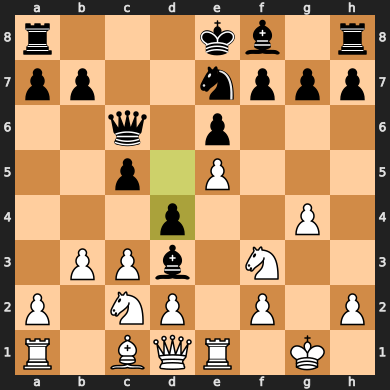

Stockfish plays: d5d4
Fallback to Stockfish: f3d4
Model plays: f3d4


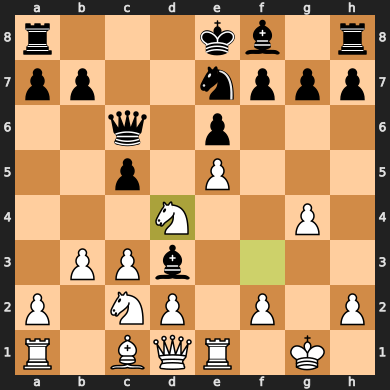

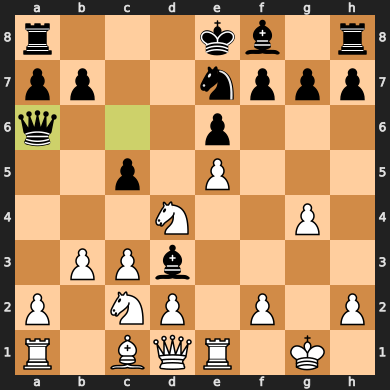

Stockfish plays: c6a6
Fallback to Stockfish: c3c4
Model plays: c3c4


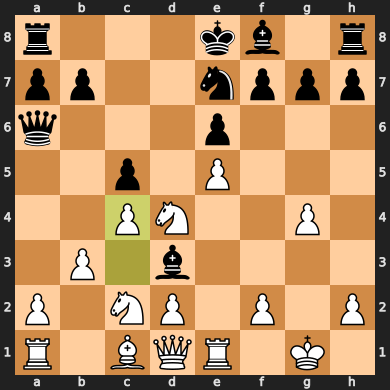

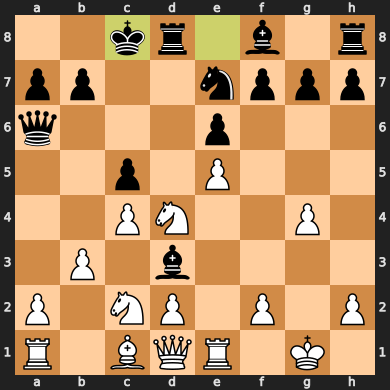

Stockfish plays: e8c8
Fallback to Stockfish: e1e3
Model plays: e1e3


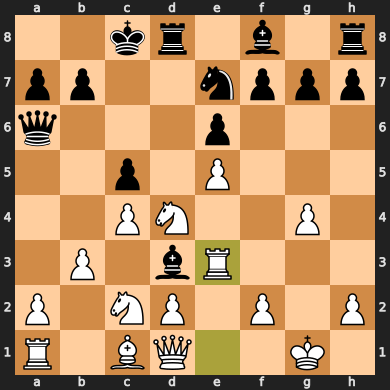

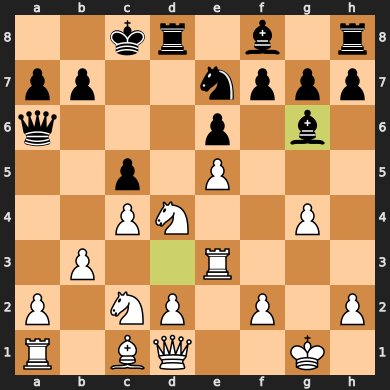

Stockfish plays: d3g6
Fallback to Stockfish: d4b5
Model plays: d4b5


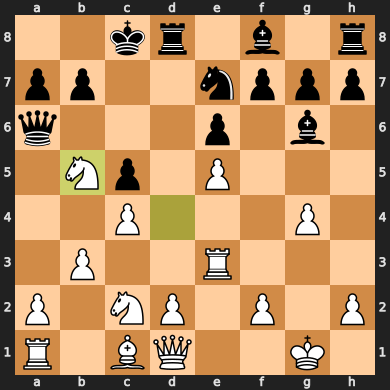

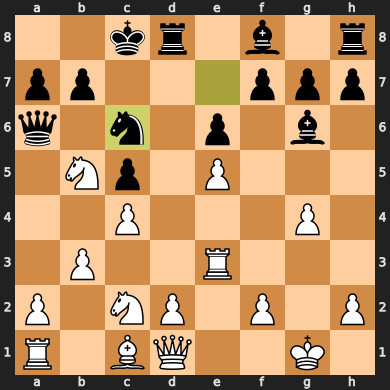

Stockfish plays: e7c6
Fallback to Stockfish: c2e1
Model plays: c2e1


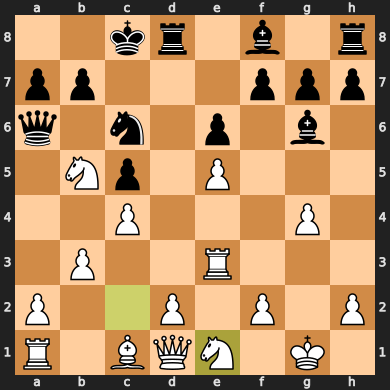

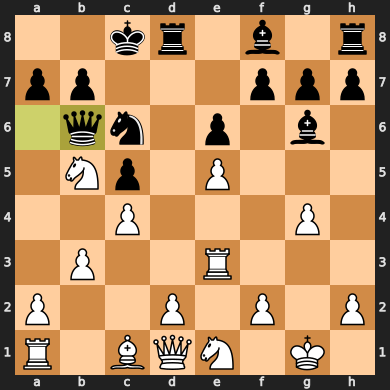

Stockfish plays: a6b6
Fallback to Stockfish: d2d3
Model plays: d2d3


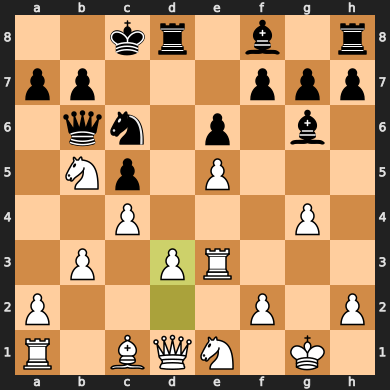

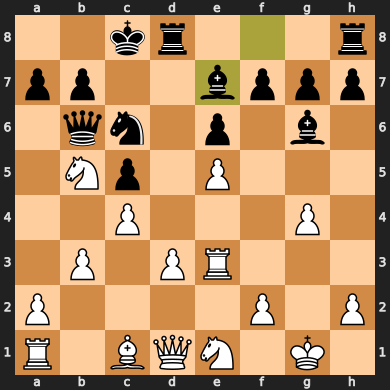

Stockfish plays: f8e7
Fallback to Stockfish: c1b2
Model plays: c1b2


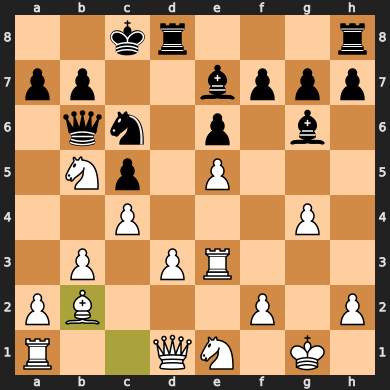

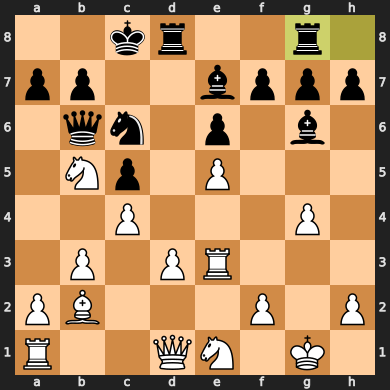

Stockfish plays: h8g8
Fallback to Stockfish: d1f3
Model plays: d1f3


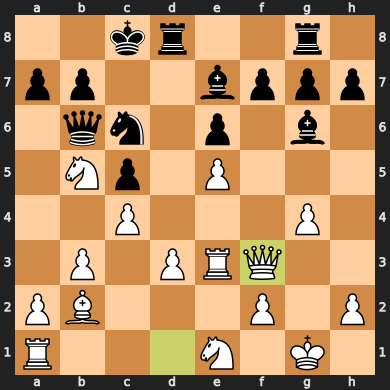

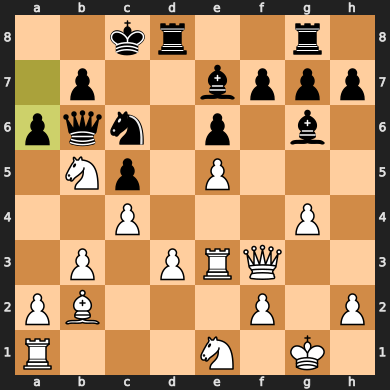

Stockfish plays: a7a6
Fallback to Stockfish: b5c3
Model plays: b5c3


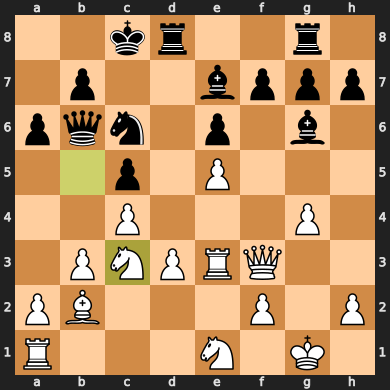

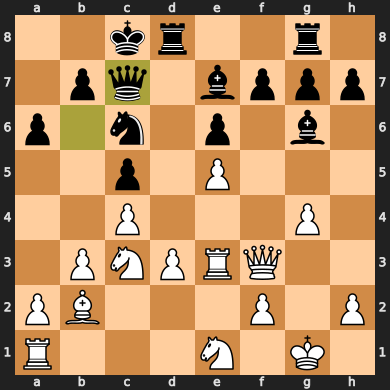

Stockfish plays: b6c7
Fallback to Stockfish: c3e2
Model plays: c3e2


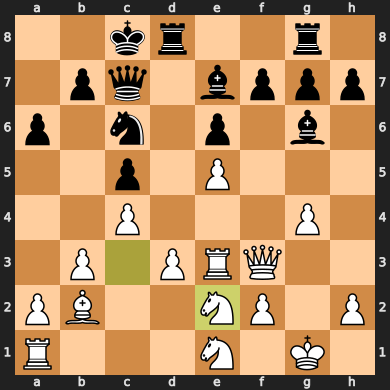

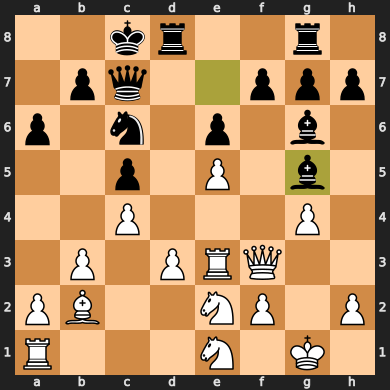

Stockfish plays: e7g5
Fallback to Stockfish: b2c3
Model plays: b2c3


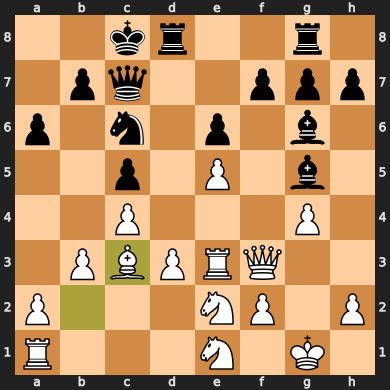

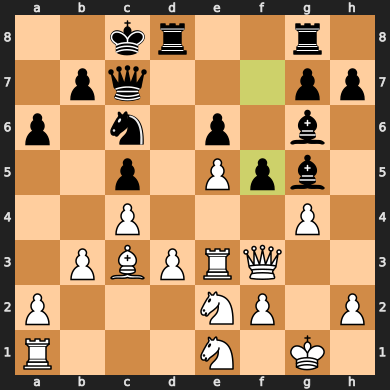

Stockfish plays: f7f5
Fallback to Stockfish: e5f6
Model plays: e5f6


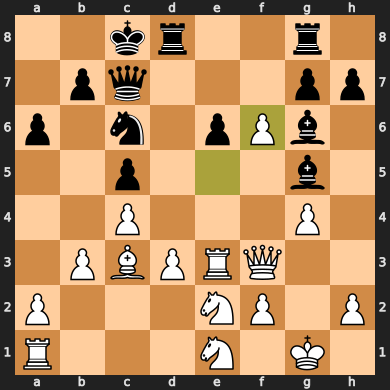

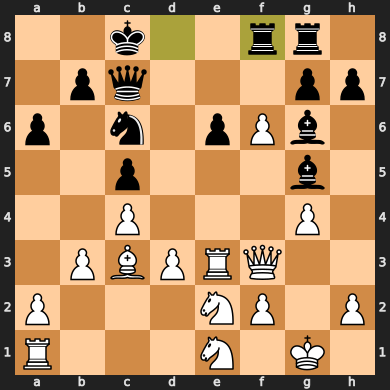

Stockfish plays: d8f8
Fallback to Stockfish: e3e6
Model plays: e3e6


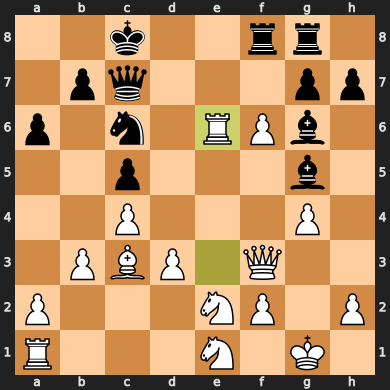

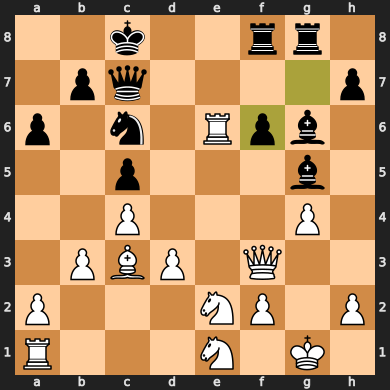

Stockfish plays: g7f6
Fallback to Stockfish: f3g3
Model plays: f3g3


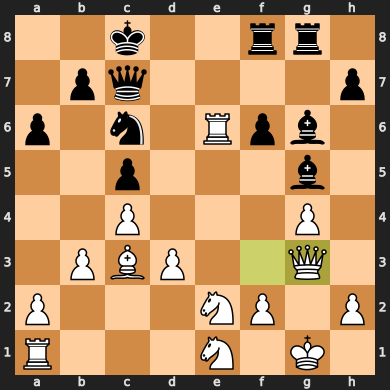

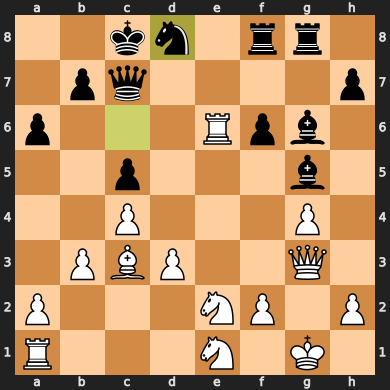

Stockfish plays: c6d8
Fallback to Stockfish: g3c7
Model plays: g3c7


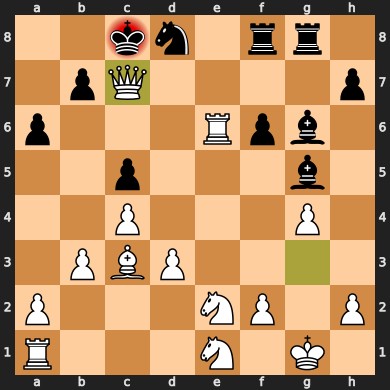

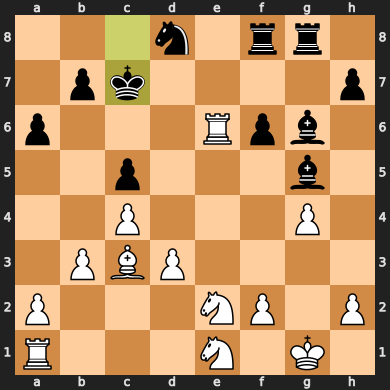

Stockfish plays: c8c7
Fallback to Stockfish: e6e4
Model plays: e6e4


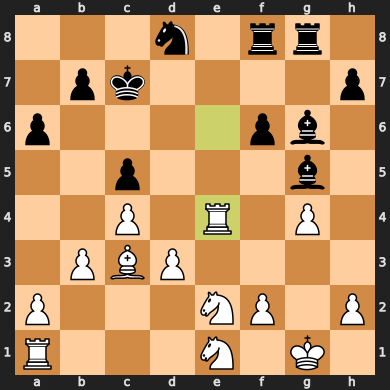

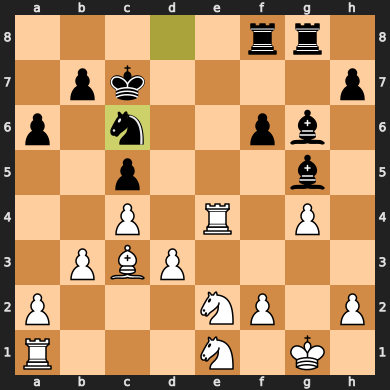

Stockfish plays: d8c6
Fallback to Stockfish: f2f4
Model plays: f2f4


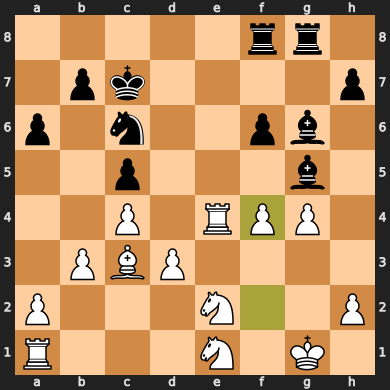

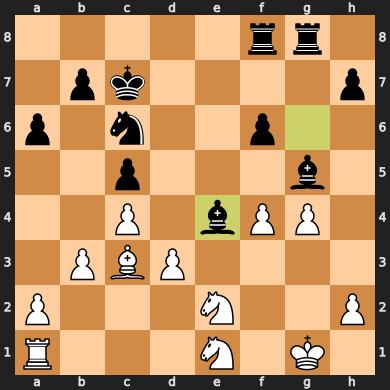

Stockfish plays: g6e4
Fallback to Stockfish: f4g5
Model plays: f4g5


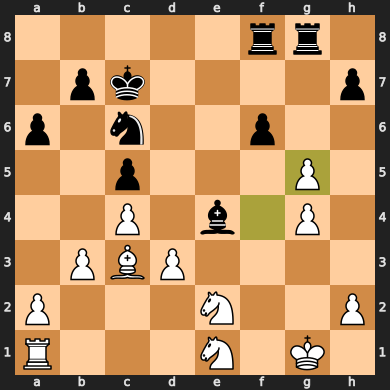

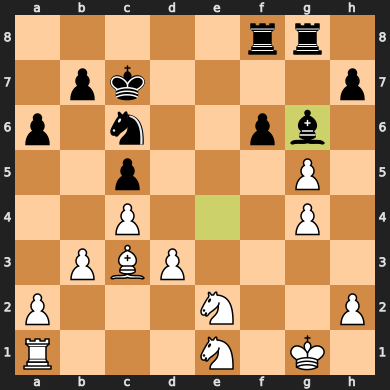

Stockfish plays: e4g6
Fallback to Stockfish: g5f6
Model plays: g5f6


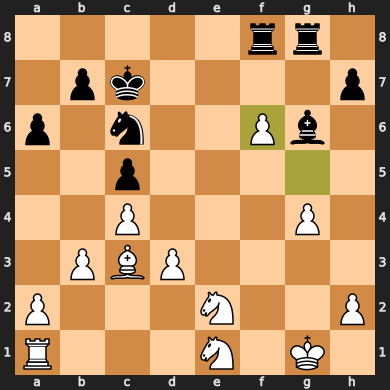

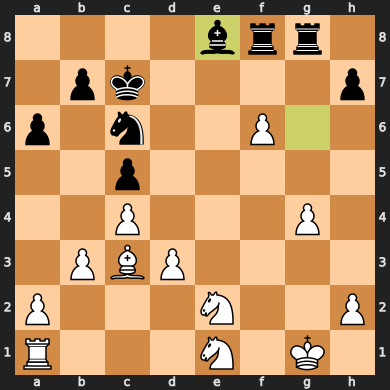

Stockfish plays: g6e8
Fallback to Stockfish: h2h3
Model plays: h2h3


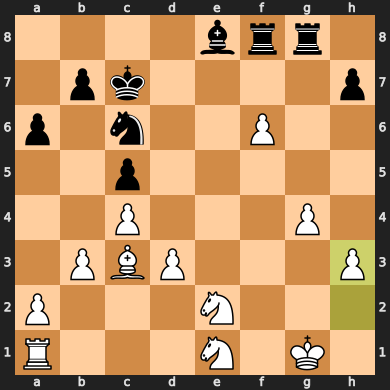

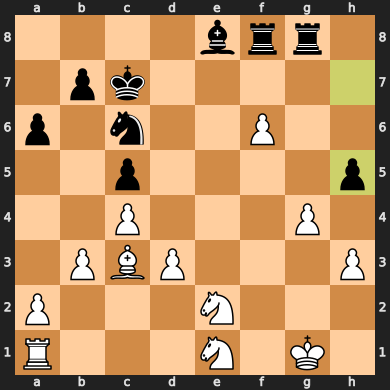

Stockfish plays: h7h5
Fallback to Stockfish: e1g2
Model plays: e1g2


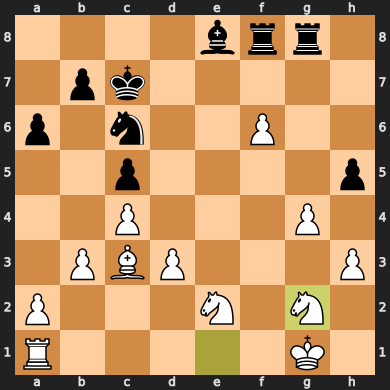

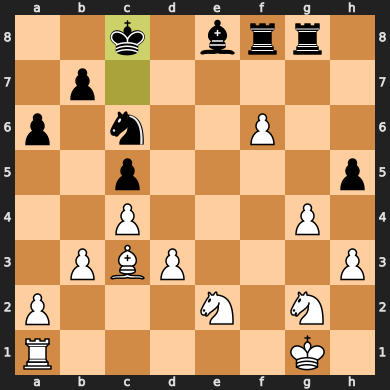

Stockfish plays: c7c8
Fallback to Stockfish: g2e3
Model plays: g2e3


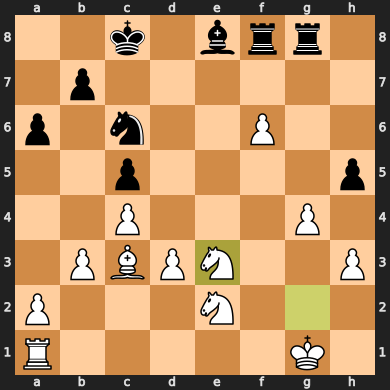

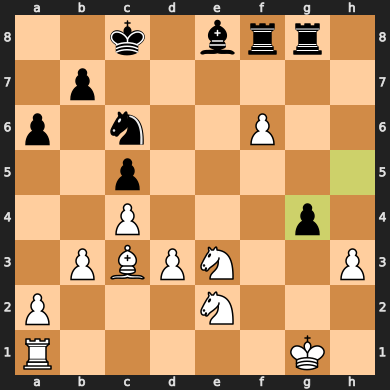

Stockfish plays: h5g4
Fallback to Stockfish: h3h4
Model plays: h3h4


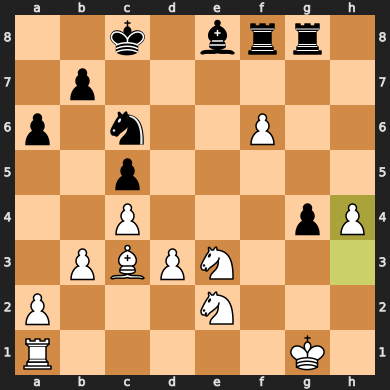

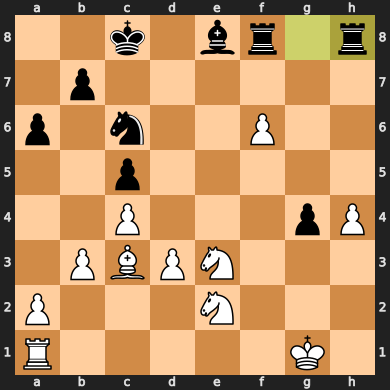

Stockfish plays: g8h8
Fallback to Stockfish: f6f7
Model plays: f6f7


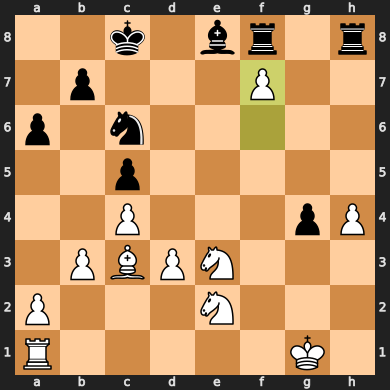

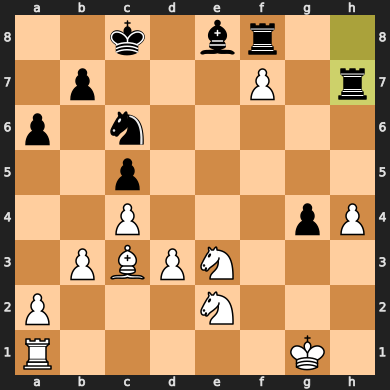

Stockfish plays: h8h7
Fallback to Stockfish: f7e8r
Model plays: f7e8r


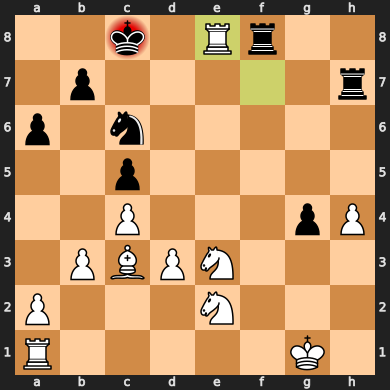

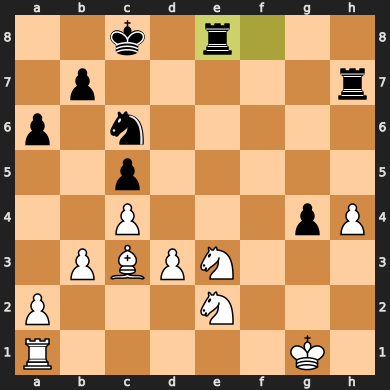

Stockfish plays: f8e8
Fallback to Stockfish: c3d2
Model plays: c3d2


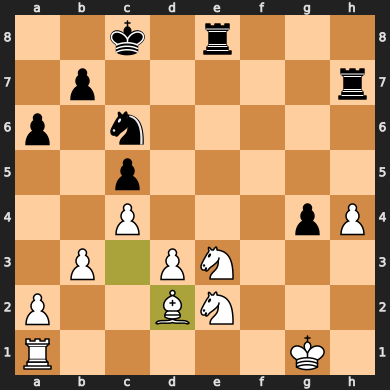

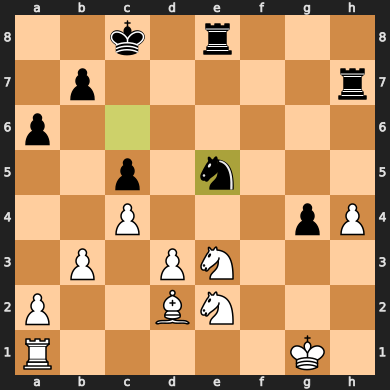

Stockfish plays: c6e5
Fallback to Stockfish: e3f5
Model plays: e3f5


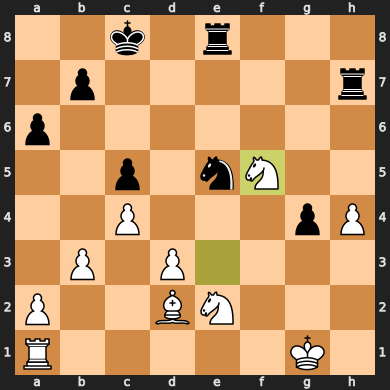

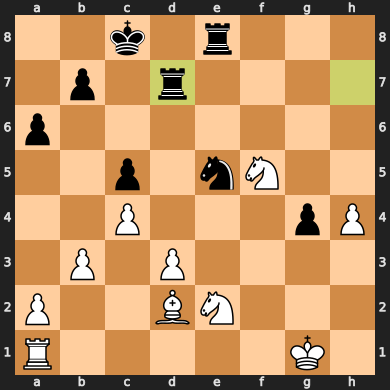

Stockfish plays: h7d7
Fallback to Stockfish: g1h1
Model plays: g1h1


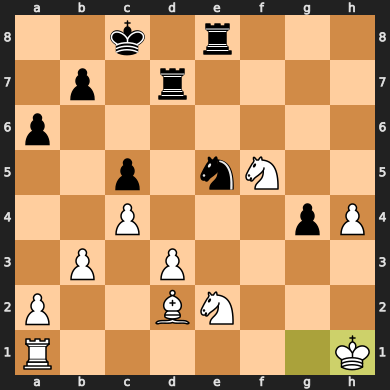

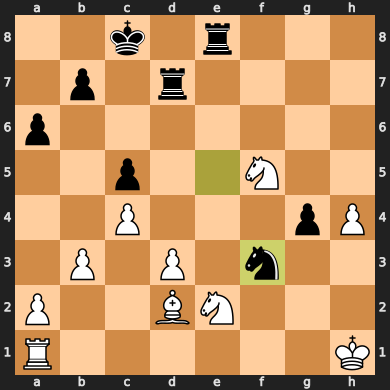

Stockfish plays: e5f3
Fallback to Stockfish: d2e3
Model plays: d2e3


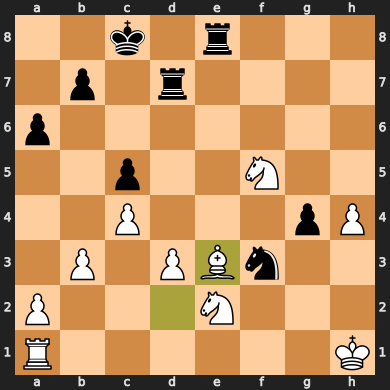

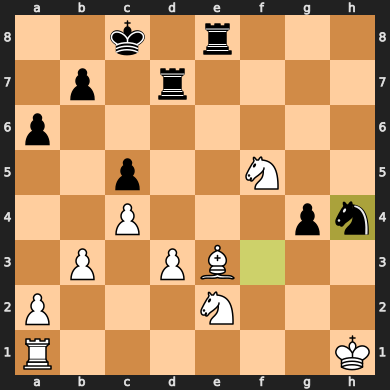

Stockfish plays: f3h4
Fallback to Stockfish: f5h4
Model plays: f5h4


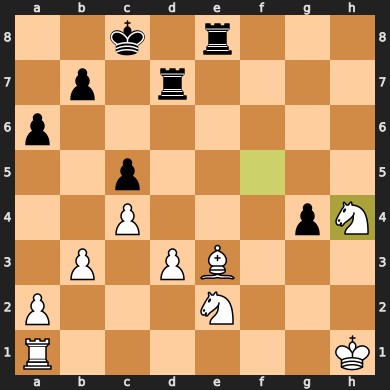

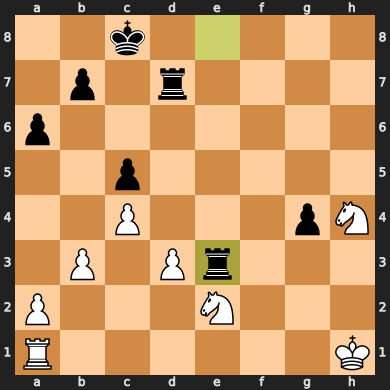

Stockfish plays: e8e3
Fallback to Stockfish: e2f4
Model plays: e2f4


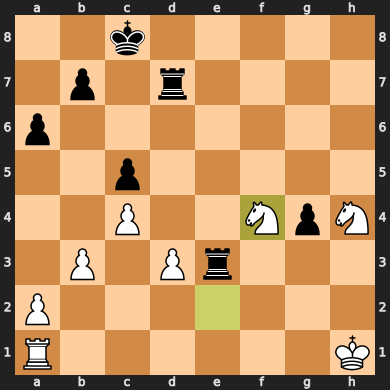

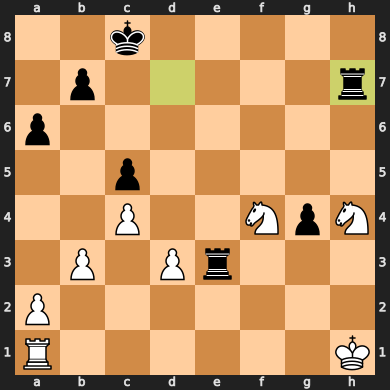

Stockfish plays: d7h7
Fallback to Stockfish: f4g2
Model plays: f4g2


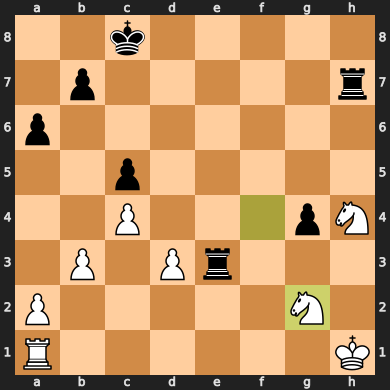

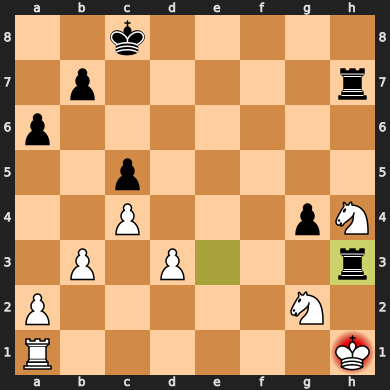

Stockfish plays: e3h3
Fallback to Stockfish: h1g1
Model plays: h1g1


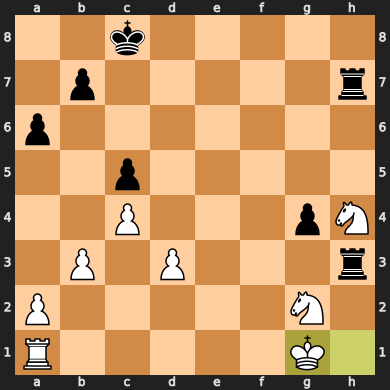

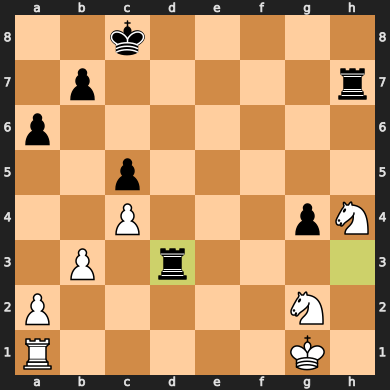

Stockfish plays: h3d3
Fallback to Stockfish: h4f5
Model plays: h4f5


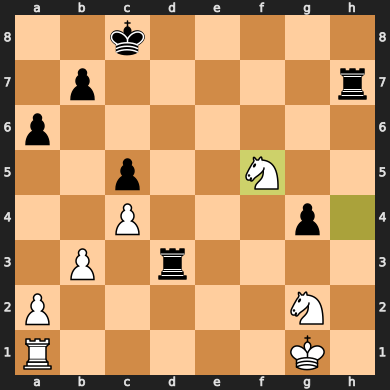

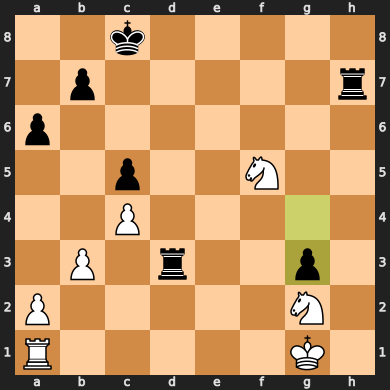

Stockfish plays: g4g3
Fallback to Stockfish: a1f1
Model plays: a1f1


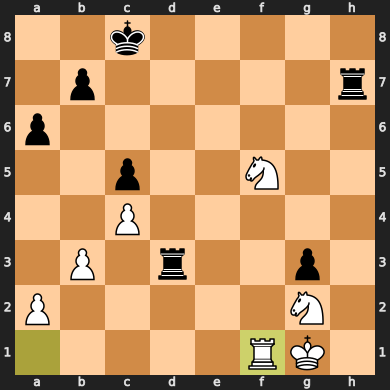

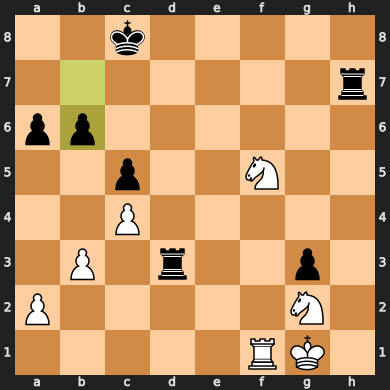

Stockfish plays: b7b6
Fallback to Stockfish: g2f4
Model plays: g2f4


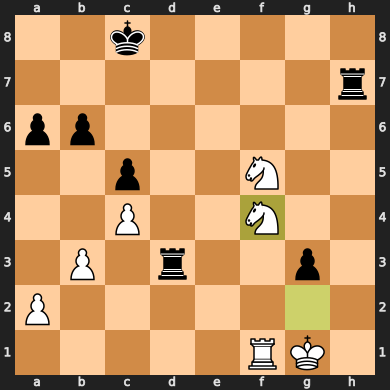

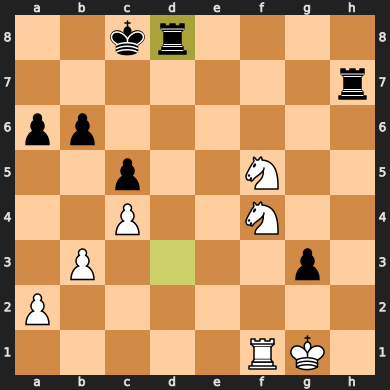

Stockfish plays: d3d8
Fallback to Stockfish: f4d5
Model plays: f4d5


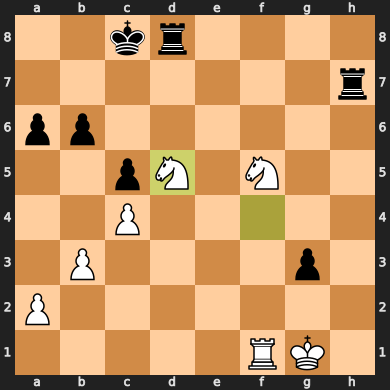

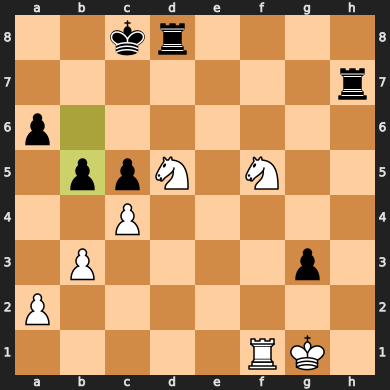

Stockfish plays: b6b5
Fallback to Stockfish: f5e7
Model plays: f5e7


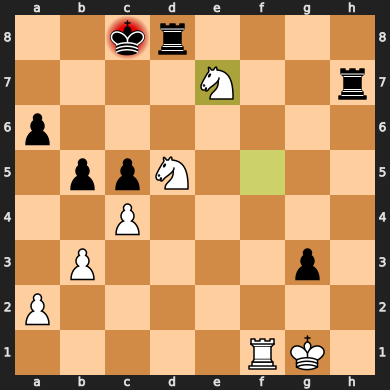

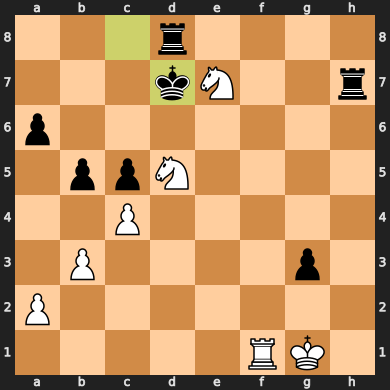

Stockfish plays: c8d7
Fallback to Stockfish: e7f5
Model plays: e7f5


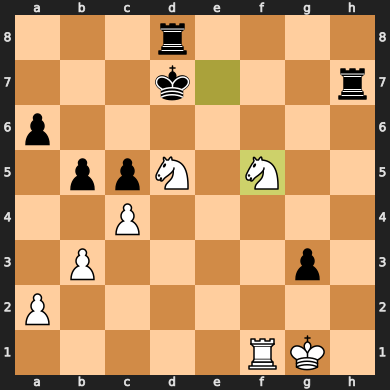

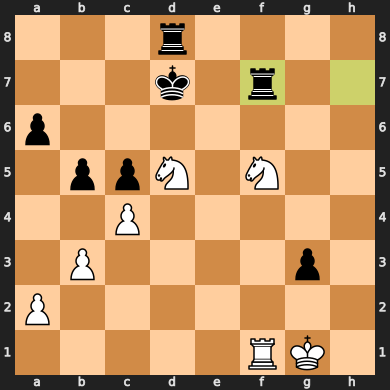

Stockfish plays: h7f7
Fallback to Stockfish: g1g2
Model plays: g1g2


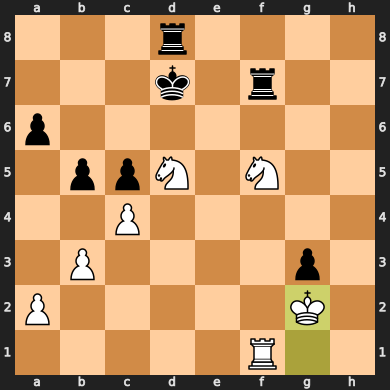

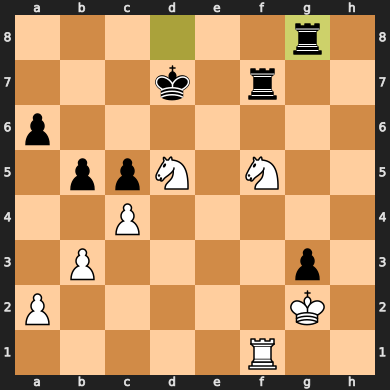

Stockfish plays: d8g8
Fallback to Stockfish: a2a4
Model plays: a2a4


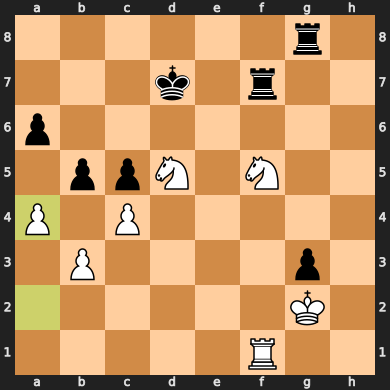

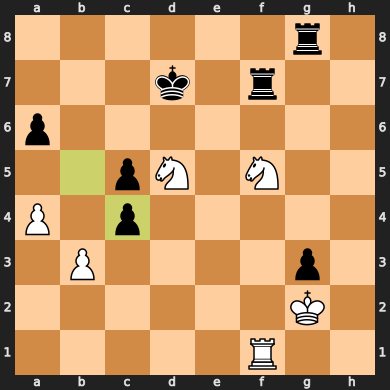

Stockfish plays: b5c4
Fallback to Stockfish: d5e7
Model plays: d5e7


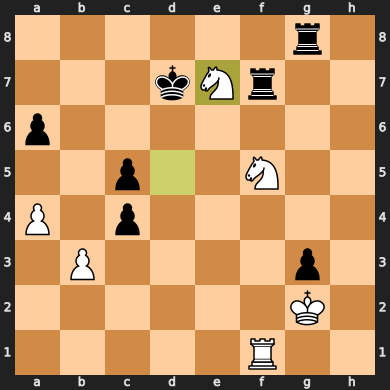

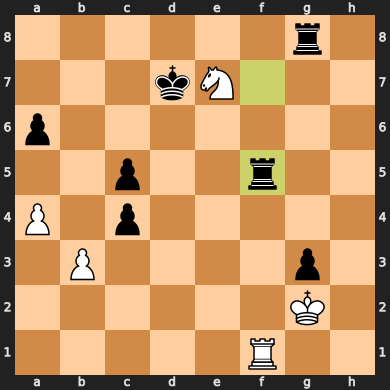

Stockfish plays: f7f5
Fallback to Stockfish: e7f5
Model plays: e7f5


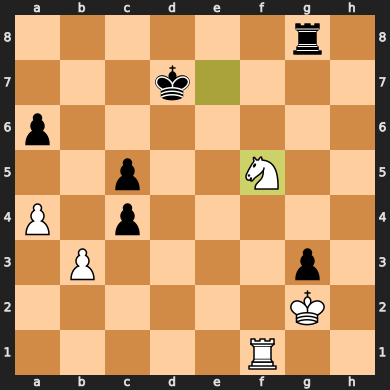

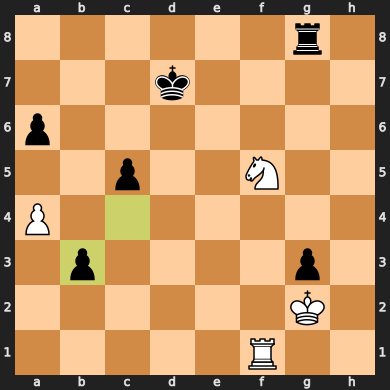

Stockfish plays: c4b3
Fallback to Stockfish: f1d1
Model plays: f1d1


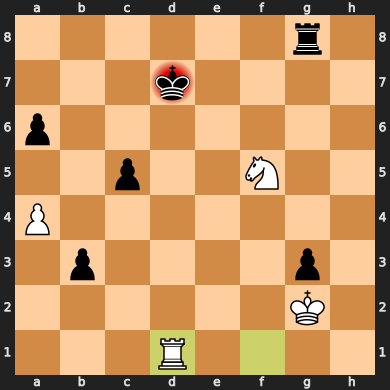

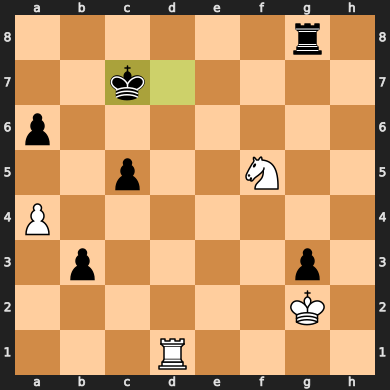

Stockfish plays: d7c7
Fallback to Stockfish: f5e3
Model plays: f5e3


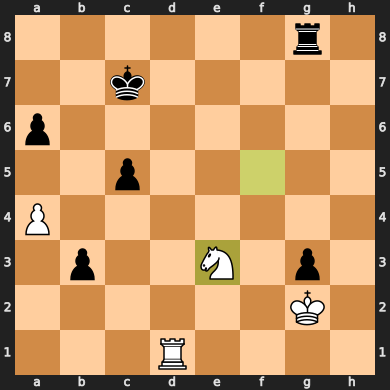

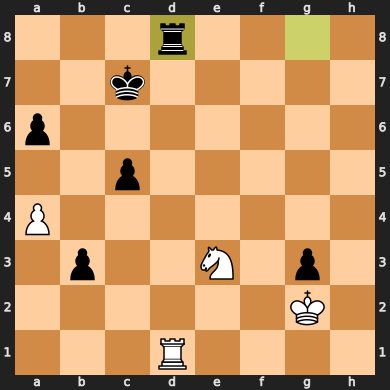

Stockfish plays: g8d8
Fallback to Stockfish: d1e1
Model plays: d1e1


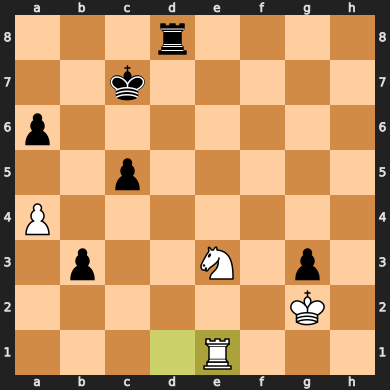

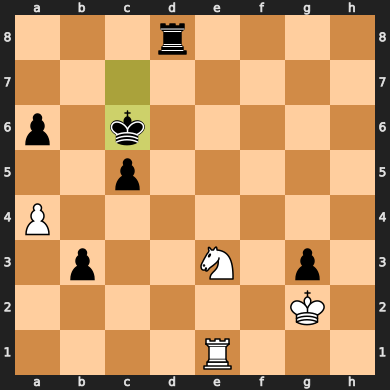

Stockfish plays: c7c6
Fallback to Stockfish: e3c4
Model plays: e3c4


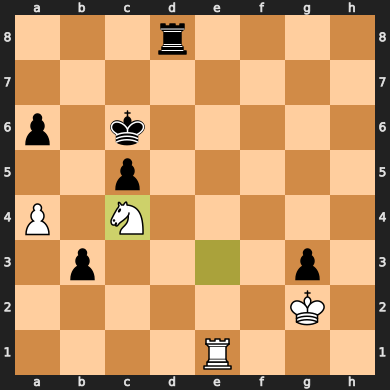

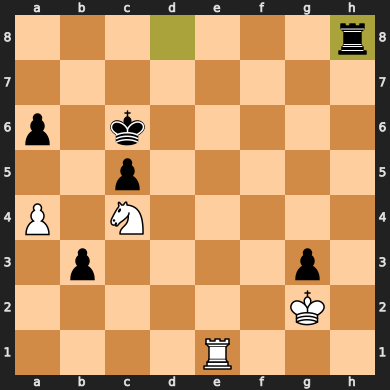

Stockfish plays: d8h8
Fallback to Stockfish: e1e5
Model plays: e1e5


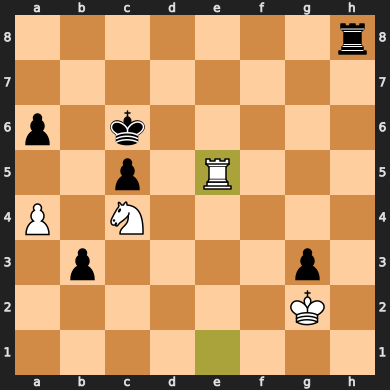

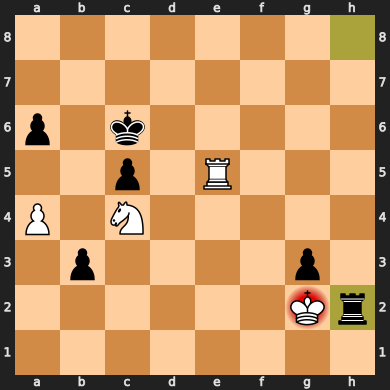

Stockfish plays: h8h2
Fallback to Stockfish: g2f1
Model plays: g2f1


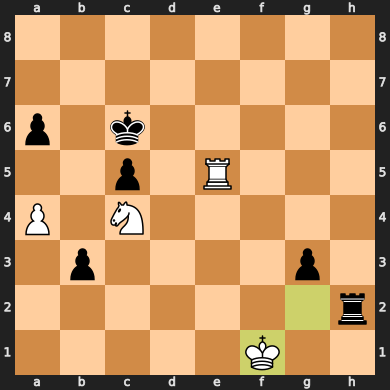

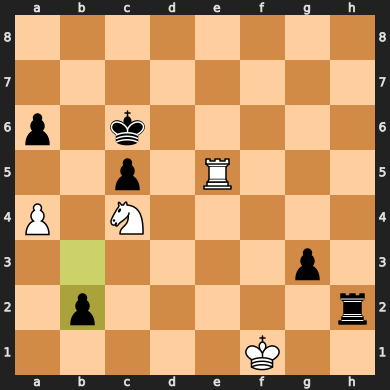

Stockfish plays: b3b2
Fallback to Stockfish: c4a3
Model plays: c4a3


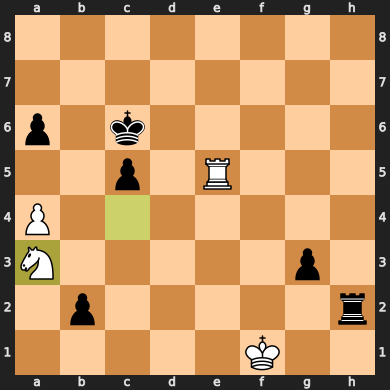

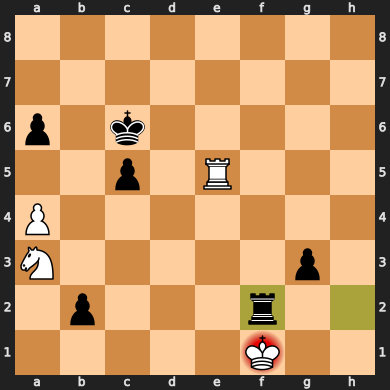

Stockfish plays: h2f2
Fallback to Stockfish: f1g1
Model plays: f1g1


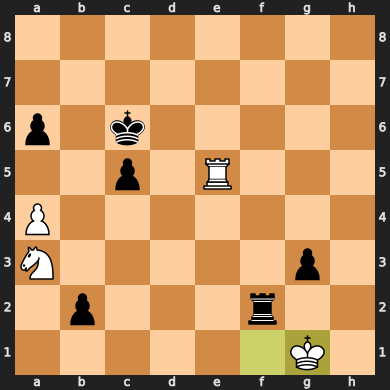

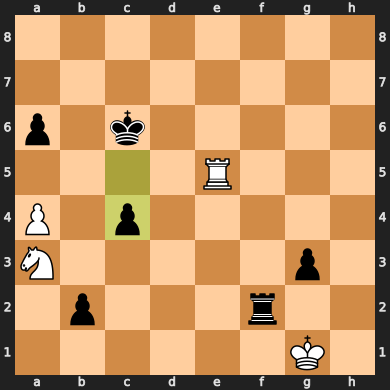

Stockfish plays: c5c4
Fallback to Stockfish: e5g5
Model plays: e5g5


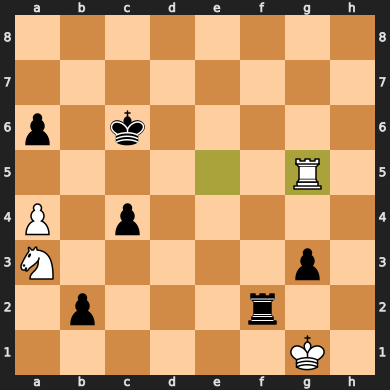

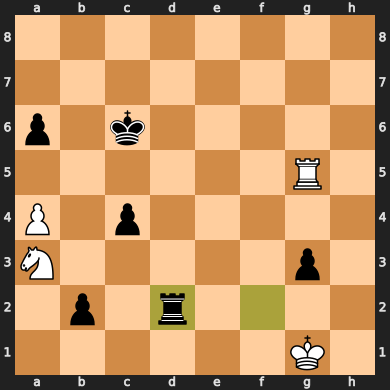

Stockfish plays: f2d2
Fallback to Stockfish: g5g3
Model plays: g5g3


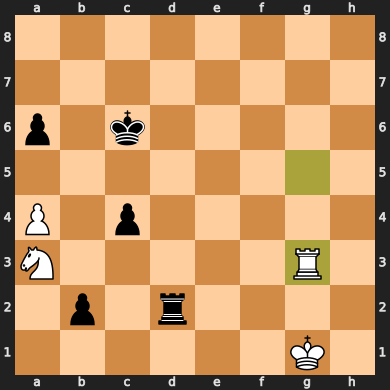

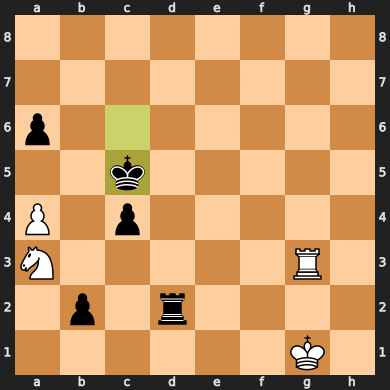

Stockfish plays: c6c5
Fallback to Stockfish: g3e3
Model plays: g3e3


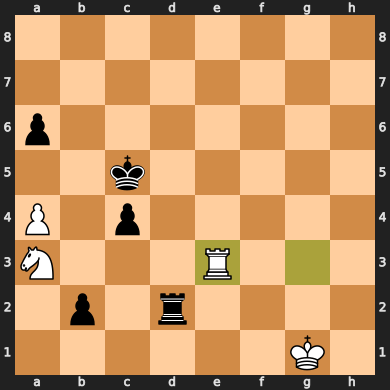

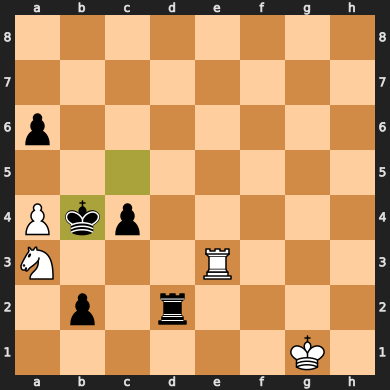

Stockfish plays: c5b4
Fallback to Stockfish: e3f3
Model plays: e3f3


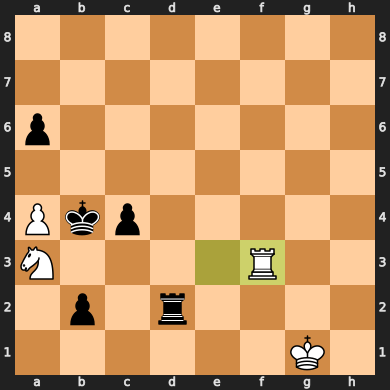

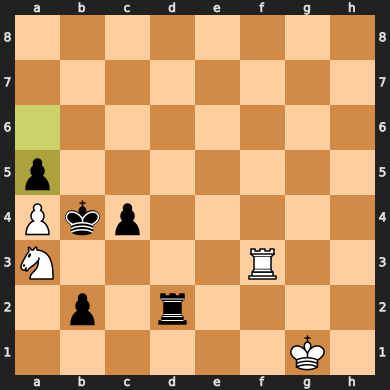

Stockfish plays: a6a5
Fallback to Stockfish: g1h1
Model plays: g1h1


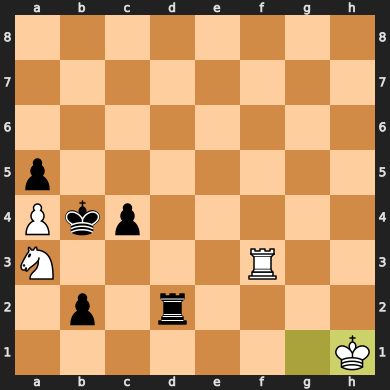

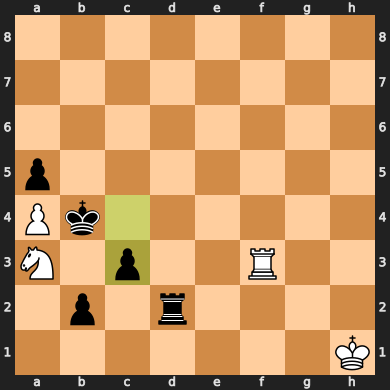

Stockfish plays: c4c3
Fallback to Stockfish: a3b1
Model plays: a3b1


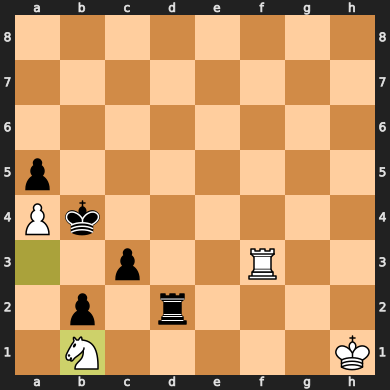

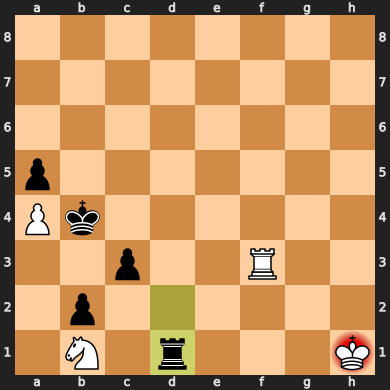

Stockfish plays: d2d1
Fallback to Stockfish: h1h2
Model plays: h1h2


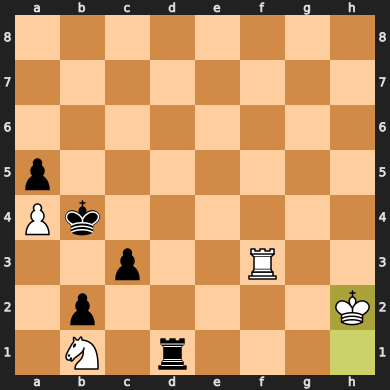

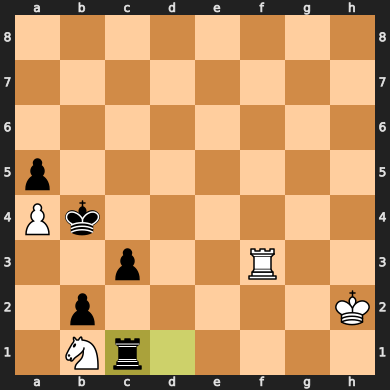

Stockfish plays: d1c1
Fallback to Stockfish: f3f4
Model plays: f3f4


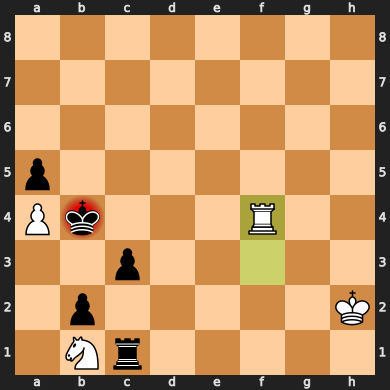

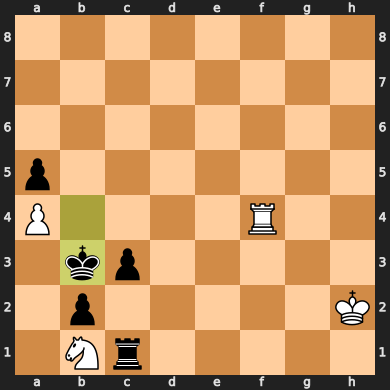

Stockfish plays: b4b3
Fallback to Stockfish: b1c3
Model plays: b1c3


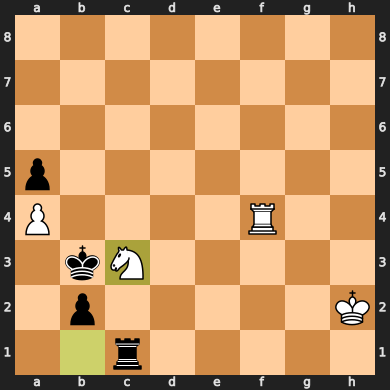

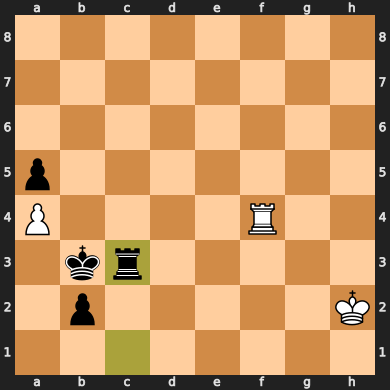

Stockfish plays: c1c3
Fallback to Stockfish: f4f8
Model plays: f4f8


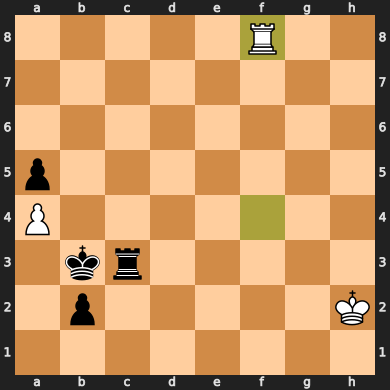

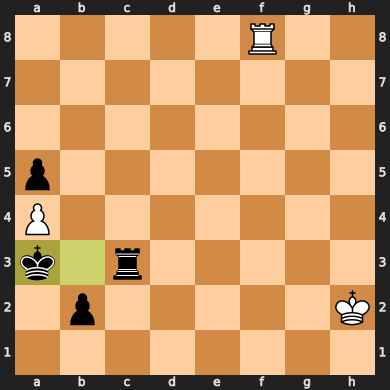

Stockfish plays: b3a3
Fallback to Stockfish: f8f1
Model plays: f8f1


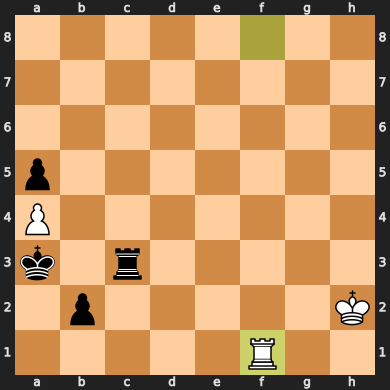

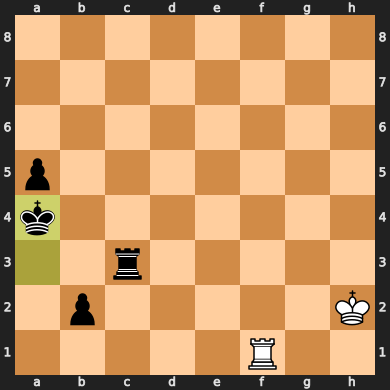

Stockfish plays: a3a4
Fallback to Stockfish: f1f3
Model plays: f1f3


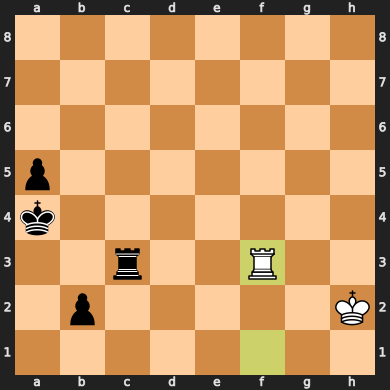

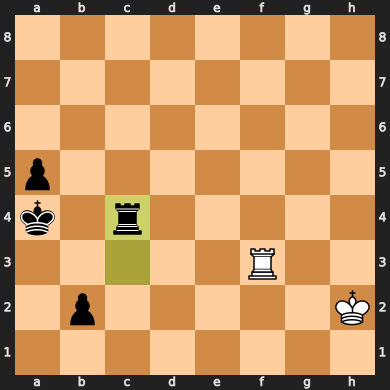

Stockfish plays: c3c4
Fallback to Stockfish: h2h3
Model plays: h2h3


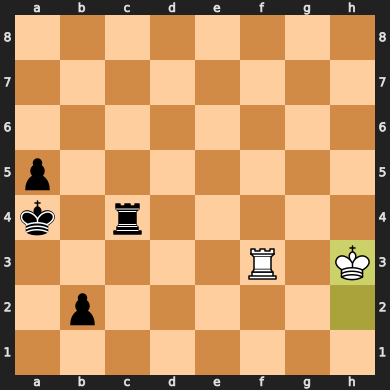

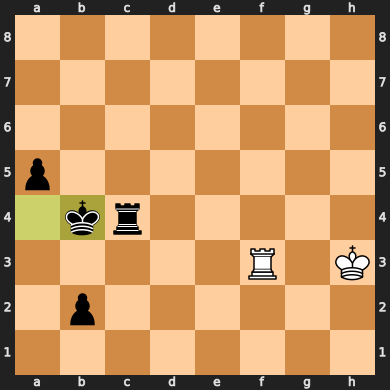

Stockfish plays: a4b4
Fallback to Stockfish: f3f6
Model plays: f3f6


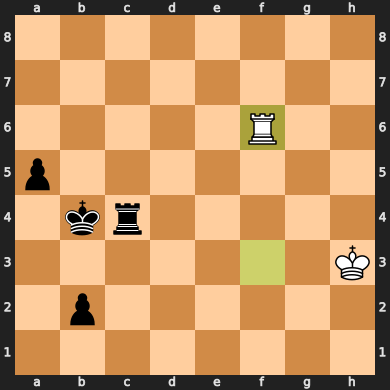

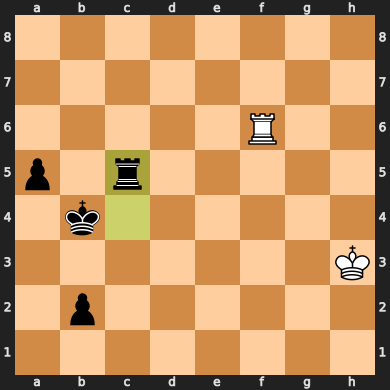

Stockfish plays: c4c5
Fallback to Stockfish: h3g2
Model plays: h3g2


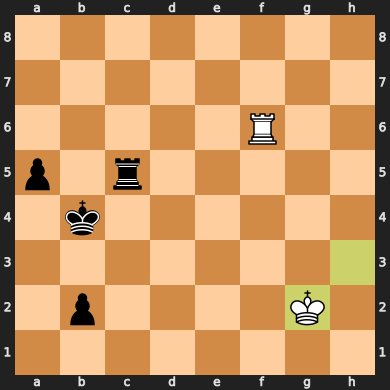

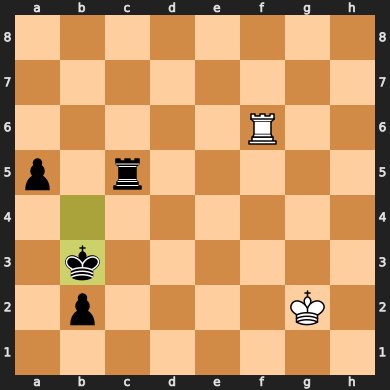

Stockfish plays: b4b3
Fallback to Stockfish: f6d6
Model plays: f6d6


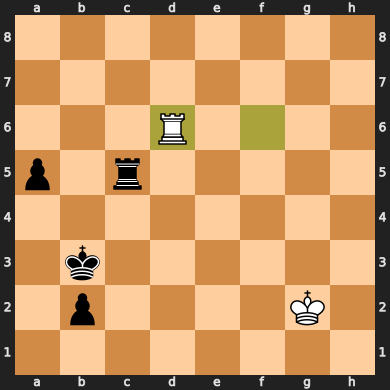

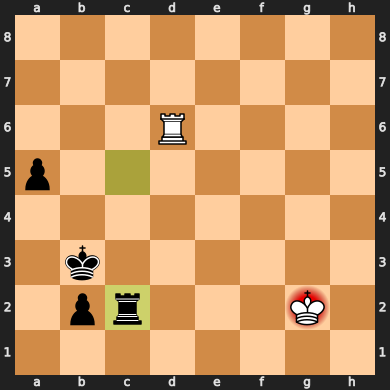

Stockfish plays: c5c2
Fallback to Stockfish: g2f3
Model plays: g2f3


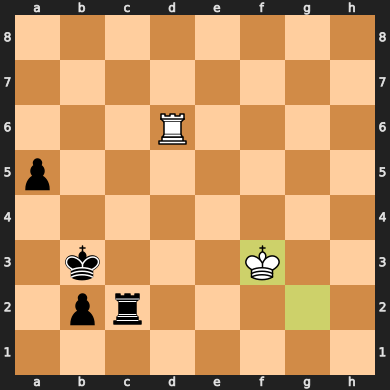

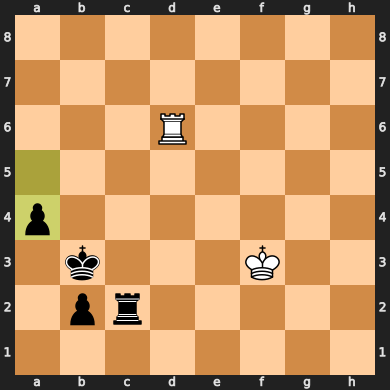

Stockfish plays: a5a4
Fallback to Stockfish: d6e6
Model plays: d6e6


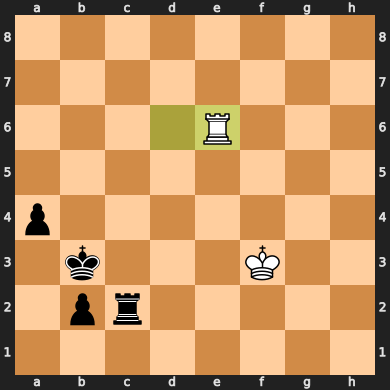

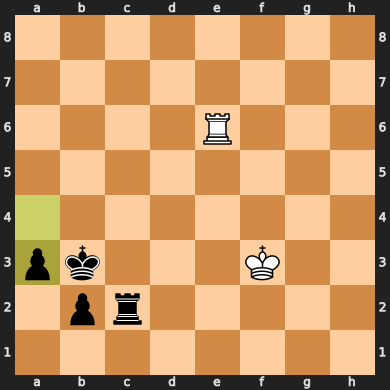

Stockfish plays: a4a3
Fallback to Stockfish: e6e1
Model plays: e6e1


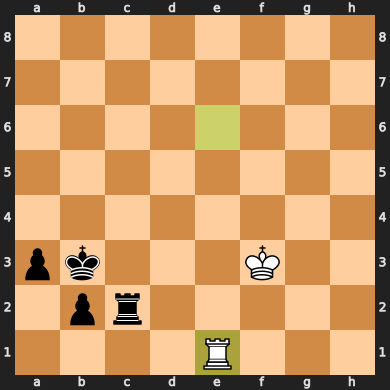

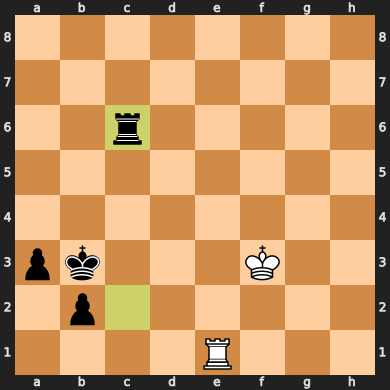

Stockfish plays: c2c6
Fallback to Stockfish: f3g4
Model plays: f3g4


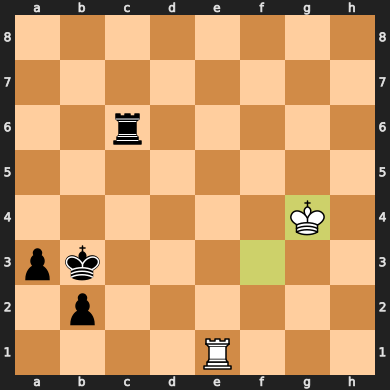

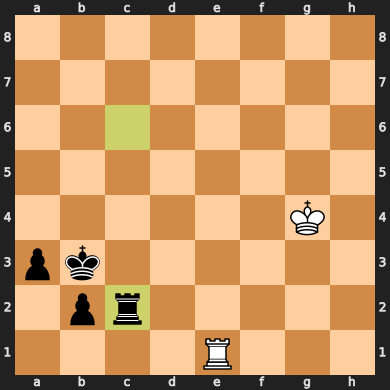

Stockfish plays: c6c2
Fallback to Stockfish: g4f3
Model plays: g4f3


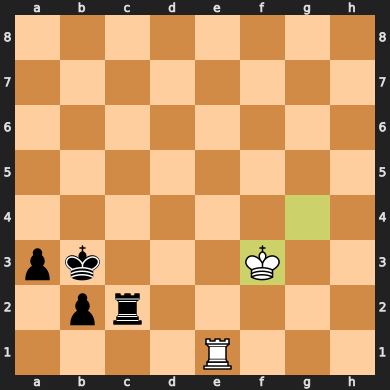

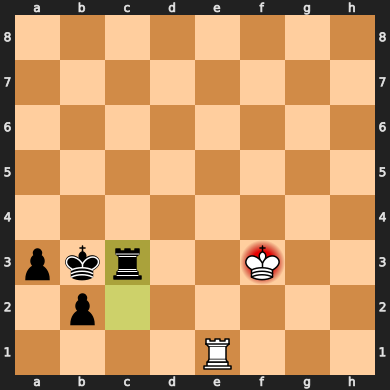

Stockfish plays: c2c3
Fallback to Stockfish: f3f2
Model plays: f3f2


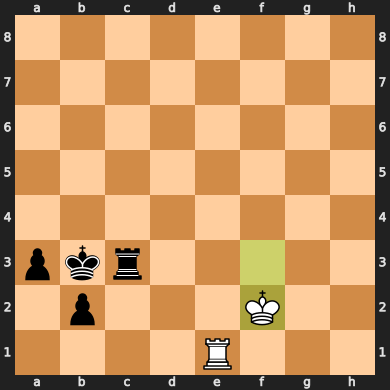

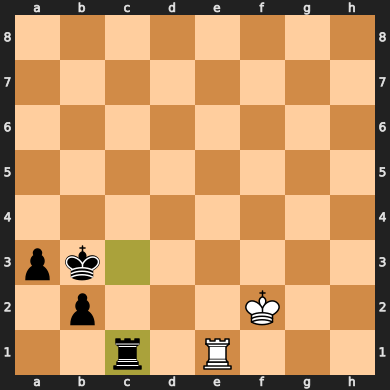

Stockfish plays: c3c1
Fallback to Stockfish: e1e3
Model plays: e1e3


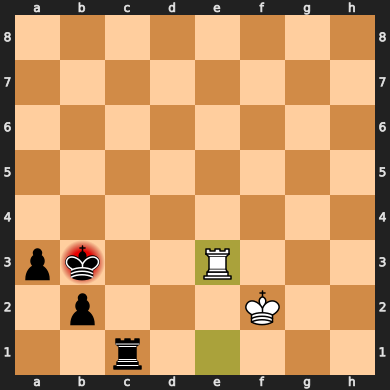

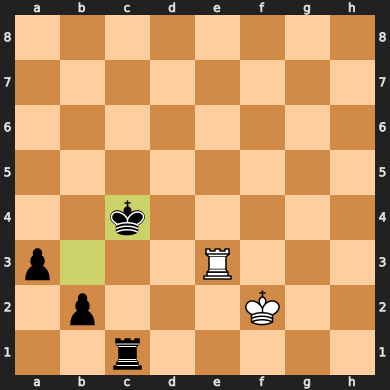

Stockfish plays: b3c4
Fallback to Stockfish: f2f3
Model plays: f2f3


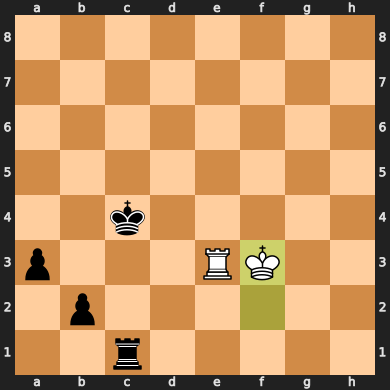

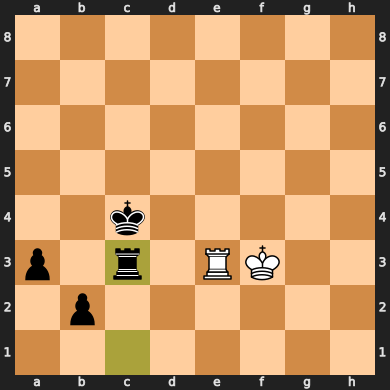

Stockfish plays: c1c3
Fallback to Stockfish: e3d3
Model plays: e3d3


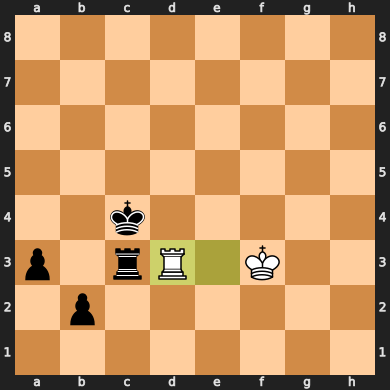

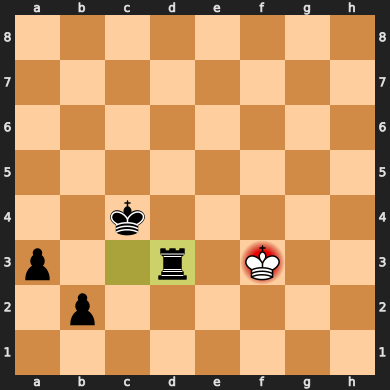

Stockfish plays: c3d3
Fallback to Stockfish: f3g4
Model plays: f3g4


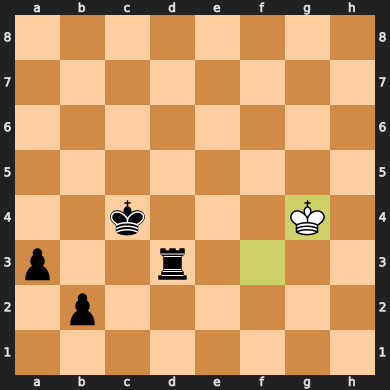

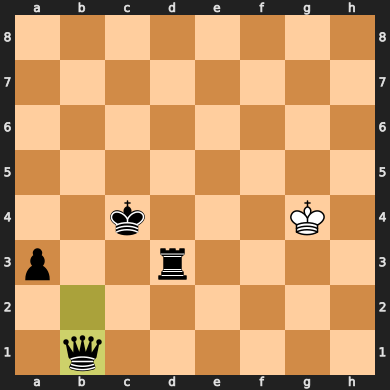

Stockfish plays: b2b1q
Fallback to Stockfish: g4f5
Model plays: g4f5


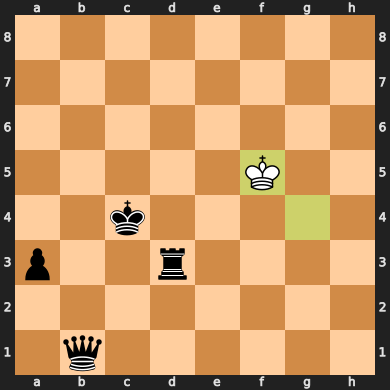

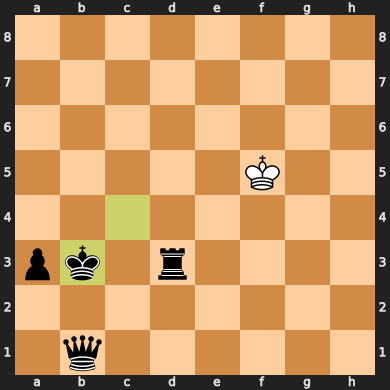

Stockfish plays: c4b3
Fallback to Stockfish: f5g4
Model plays: f5g4


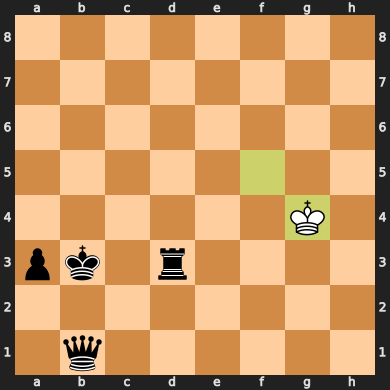

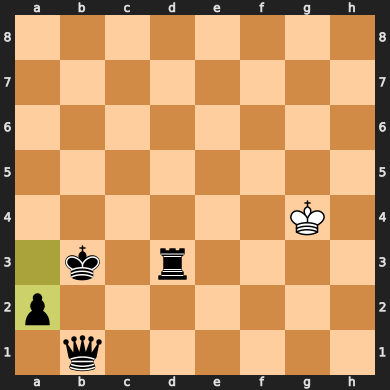

Stockfish plays: a3a2
Fallback to Stockfish: g4h5
Model plays: g4h5


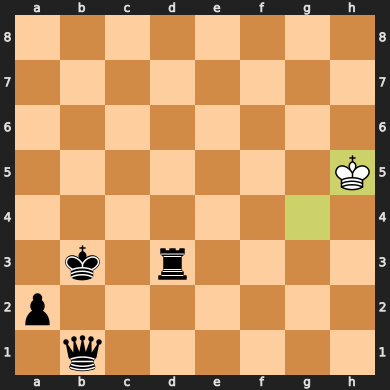

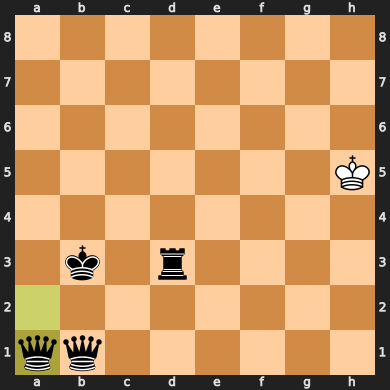

Stockfish plays: a2a1q
Fallback to Stockfish: h5g5
Model plays: h5g5


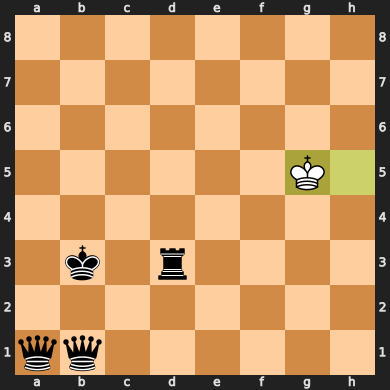

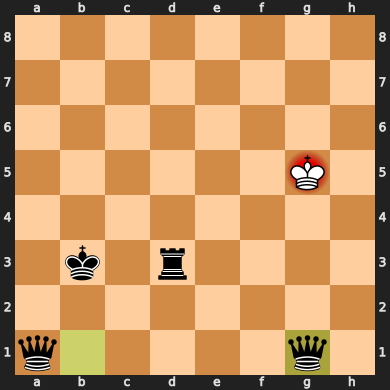

Stockfish plays: b1g1
Fallback to Stockfish: g5h6
Model plays: g5h6


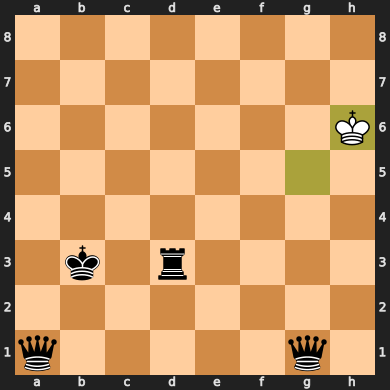

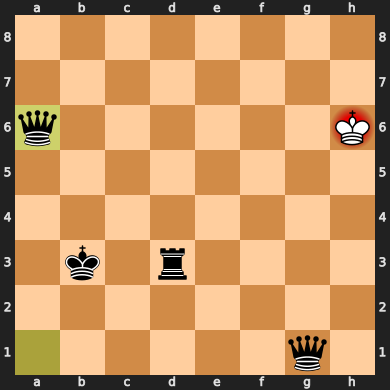

Stockfish plays: a1a6
Fallback to Stockfish: h6h5
Model plays: h6h5


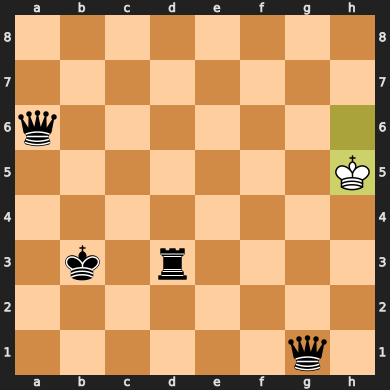

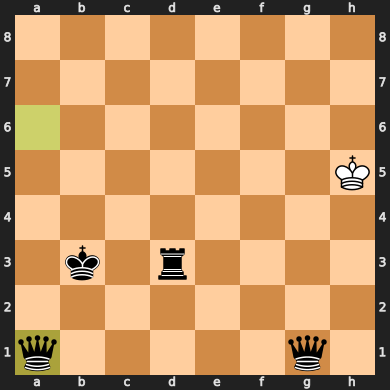

Stockfish plays: a6a1
Fallback to Stockfish: h5h4
Model plays: h5h4


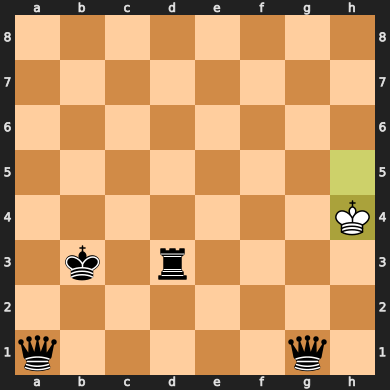

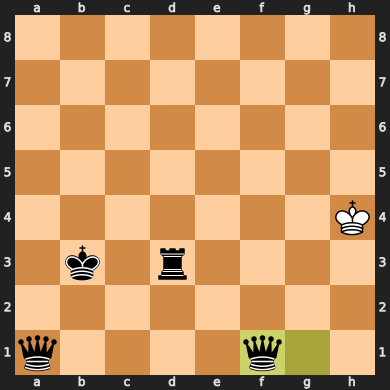

Stockfish plays: g1f1
Fallback to Stockfish: h4g4
Model plays: h4g4


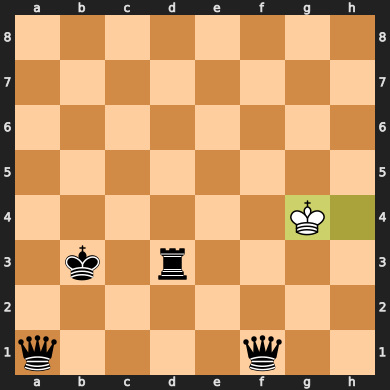

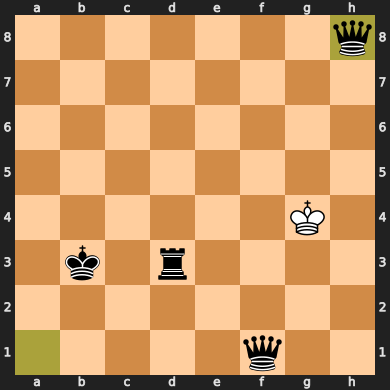

Stockfish plays: a1h8
Fallback to Stockfish: g4g5
Model plays: g4g5


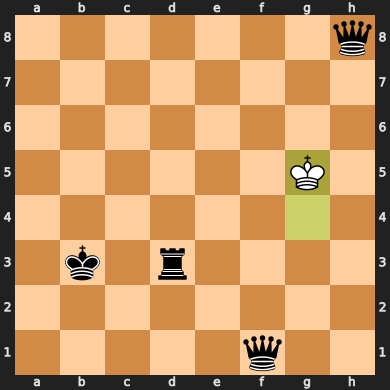

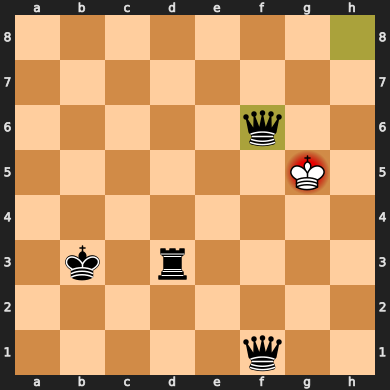

Stockfish plays: h8f6
Fallback to Stockfish: g5g4
Model plays: g5g4


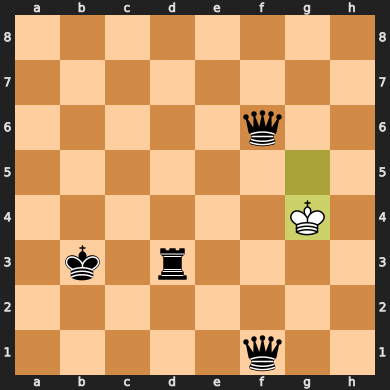

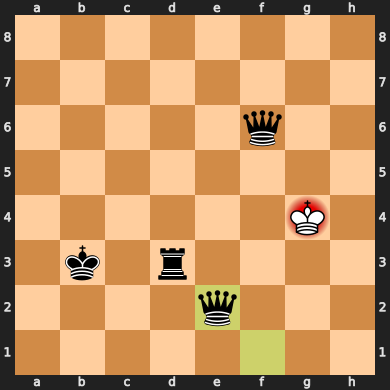

Stockfish plays: f1e2

Game over! Result: 0-1
Stockfish (zwart) wint!


In [16]:
import chess
import chess.engine
import random

# Start engine
engine = chess.engine.SimpleEngine.popen_uci(STOCKFISH_PATH)
engine.configure({
    "UCI_LimitStrength": True,
    "UCI_Elo": 2300
})

board = chess.Board()

# Randomly decide who plays white
if random.random() < 0.5:
    model_color = chess.WHITE
    engine_color = chess.BLACK
    print("Model plays white and begins!")
else:
    model_color = chess.BLACK
    engine_color = chess.WHITE
    print("Stockfish plays white and begins!")

while not board.is_game_over():

    # === Selfmade MODEL ===
    df_move = recommend_moves_with_entropy(board.fen(), move_stats, n=1)

    # --- SAFE MOVE SELECTION ---
    if df_move is None or df_move.empty or "move" not in df_move.columns:
        # Fallback: Stockfish speelt
        move_to_play = engine.play(
            board, chess.engine.Limit(depth=12)
        ).move.uci()
        print("Fallback to Stockfish:", move_to_play)
    else:
        move_to_play = df_move.iloc[0]["move"]

    # Zet om naar chess.Move
    my_move = chess.Move.from_uci(move_to_play)

    # Laatste veiligheidscheck
    if my_move not in board.legal_moves:
        # Ultime fallback
        my_move = list(board.legal_moves)[0]
        move_to_play = my_move.uci()
        print("Illegal move replaced with:", move_to_play)

    board.push(my_move)
    print("Model plays:", move_to_play)
    display(board)

    if board.is_game_over():
        break

    # === STOCKFISH TEGENZET ===
    reply = engine.play(board, chess.engine.Limit(depth=12))
    board.push(reply.move)
    display(board)
    print("Stockfish plays:", reply.move.uci())

# ===== GAME OVER =====
result = board.result()  # e.g. "1-0", "0-1", "1/2-1/2"
print("\nGame over! Result:", result)

# Clarify who won
if result == "1-0":
    print("Model (wit) wint!")
elif result == "0-1":
    print("Stockfish (zwart) wint!")
else:
    print("Remise!")
engine.quit()
